The purpose of this note book is to gather, organize a prep the data that will be used for building a predictive model for wait times at Disney World attractions in support of objectives set by the fictional travel company, Maximo Travels.  This notebook is divided into three sections as follows:

Section 1:  This section will retrieve the historical, hourly weather for the Walt Disney World area in Orlando, FL.  The data is obtained using the meteostat package.  It will be cleaned and prepped to be merged with attraction wait time data and available metadata.

Section 2:  This section will call on files that contain historical wait times for various attractions across the four Walt Disney World parks.  The data will be compiled and processed to optimize the datasets.  The attraction wait times themselves will likely be the strongest and most significant influence on the outcome so special care will be taken not to overwork the data in this initial notebook.

Section 3:  This section will call on a metadata file that contains predictors to build a reliable model.  The data will be organized and cleaned in preparation for merging with the weather data and attraction wait time data.  Throughout these sections, some analysis will be done to get an overview of the data but primarily, this notebook will gather, organize and prep all  available data so that it can be analyzed and processed during the next step for EDA.

** The attraction data sets and meta data used for this capstone were retrieved from touringplans.com.    


Section 1:  Hourly/Daily Weather:

In [1]:
import pandas as pd
import datetime
from datetime import datetime
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Hourly
import glob
import os
import math
import numpy as np
import missingno as msno
import statsmodels.formula.api as smf

meta_file = pd.read_csv('disney_meta.csv')
meta_dict = pd.read_excel('data_dict.xlsx',sheet_name='metadata')

In [2]:
#  The below uses meteostat to pull hourly weather data for Walt Disney World Magic Kingdom (long/lat) from 2015 to 2021.

start = datetime(2015, 1, 1)
end = datetime(2021, 12, 31)
disney = Point(28.4178, -81.5753, 98)

data = Hourly(disney, start, end)
data = data.normalize().interpolate().fetch().reset_index()

hourly_wx = (data[['time','temp','prcp']]
    .assign(hrly_temp=lambda df:  (data['temp'] * 9/5) + 32)  # convert to Fahrenheit as US standard.
    .rename(columns={'time': 'datetime','temp': 'temp_celsius','prcp': 'hrly_precip'})
    [['datetime', 'hrly_temp', 'hrly_precip']])

hourly_wx.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61345 entries, 0 to 61344
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     61345 non-null  datetime64[ns]
 1   hrly_temp    61338 non-null  Float64       
 2   hrly_precip  60898 non-null  Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 1.5 MB


In [3]:
# Weather data for when the parks aren't open/no wait times isn't required, the following will remove the hours that the parks are not open.
open_hours_wx = (hourly_wx['datetime'].dt.hour < 3) | (hourly_wx['datetime'].dt.hour >= 7)
wx_open_hours = hourly_wx[open_hours_wx].copy()
wx_open_hours.head()

,datetime,hrly_temp,hrly_precip
0,2015-01-01 00:00:00,61.88,0.0
1,2015-01-01 01:00:00,61.88,0.0
2,2015-01-01 02:00:00,60.08,0.0
7,2015-01-01 07:00:00,60.26,0.0
8,2015-01-01 08:00:00,59.36,0.0


In [4]:
# the following gives me an idea of what % of data is missing.

missing = pd.concat([wx_open_hours.isnull().sum(), 100 * wx_open_hours.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by= 'count', ascending= True)

# wx_open_hours.isna().sum()

,count,%
datetime,0,0.000000
hrly_temp,5,0.009781
hrly_precip,351,0.686606


In [5]:
# My primary predictor is the wait times and less than one percent are null vals -- will ffill values instead of 
# dropping -- weather does not vary greatly from hour to hour and would rather have a fill here than have to drop a wait time later.

wx_open_hours['hrly_precip'] = wx_open_hours['hrly_precip'].ffill()
wx_open_hours['hrly_temp'] = wx_open_hours['hrly_temp'].ffill()
weather_data = wx_open_hours.copy()
weather_data['date']=weather_data['datetime'].dt.normalize()

weather_data.isna().sum()


datetime       0
hrly_temp      0
hrly_precip    0
date           0
dtype: int64

In [6]:
# adding columns for daily averages (accounting for extra mickey hours as the operational date column)

# grouping by the operational date 
weather_data['daily_avg_precip'] = weather_data.groupby('date')['hrly_precip'].transform('mean')
weather_data['daily_avg_temp'] = weather_data.groupby('date')['hrly_temp'].transform('mean')
weather_data['daily_max_temp'] = weather_data.groupby('date')['hrly_temp'].transform('max')
weather_data['daily_min_temp'] = weather_data.groupby('date')['hrly_temp'].transform('min')


In [7]:
# organizing columns and standardizing types

weather_data = weather_data[['date', 'datetime', 'hrly_precip', 'daily_avg_precip', 'hrly_temp', 'daily_avg_temp',
       'daily_min_temp','daily_max_temp']]

temp_cols = ['hrly_temp', 'daily_avg_temp','daily_max_temp', 'daily_min_temp']
precip_cols = ['hrly_precip', 'daily_avg_precip']

weather_data[temp_cols] = weather_data[temp_cols].astype(int).copy()
weather_data[precip_cols] = weather_data[precip_cols].round(2).copy()

weather = weather_data.reset_index(drop = True)
weather.head()



,date,datetime,hrly_precip,daily_avg_precip,hrly_temp,daily_avg_temp,daily_min_temp,daily_max_temp
0,2015-01-01,2015-01-01 00:00:00,0.0,0.0,61,64,59,72
1,2015-01-01,2015-01-01 01:00:00,0.0,0.0,61,64,59,72
2,2015-01-01,2015-01-01 02:00:00,0.0,0.0,60,64,59,72
3,2015-01-01,2015-01-01 07:00:00,0.0,0.0,60,64,59,72
4,2015-01-01,2015-01-01 08:00:00,0.0,0.0,59,64,59,72


In [8]:
weather.to_csv('weather.csv', index=False)

.

.

Section 2: Attraction Datasets:

.

.

In [9]:
""" The function, 'process_wait_time_data(filepath)' gathers all of the attraction dataset files, removes -999 
  default for when the parks are closed or rides are down, combines the posted and measured wait times into a single column, makes the datetime 
  columns implicit, averages wait times within the hour, resamples to hourly and adds as column to identify the original file/park attraction 
  that the wait times were for.
"""
def process_wait_time_data(filepath):

    df = pd.read_csv(filepath)
    df_filtered = df[df['SPOSTMIN'] != -999].copy()
    df_filtered['combined_wait_time'] = df_filtered['SPOSTMIN'].fillna(df_filtered['SACTMIN'])
    
    df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'], errors='coerce', dayfirst=False)
    df_filtered.dropna(subset=['datetime'], inplace=True)
    df_filtered.set_index('datetime', inplace=True)  #set the index on datetime so it can be sampled to hourly.
    
    wait_times = df_filtered['combined_wait_time'].resample('h').mean() 
    
    hourly_wait_times = wait_times.to_frame(name='wait_time').reset_index()
    hourly_wait_times['wait_time'] = np.ceil(hourly_wait_times['wait_time']).astype('Int64')
    
    hourly_wait_times['origin_file_attraction'] = os.path.basename(filepath)
    
    df_result = hourly_wait_times[['datetime', 'wait_time', 'origin_file_attraction']].copy()
    
    return df_result


In [10]:
#The following automates the loading of all attraction files stored in a directory, processing them to standardize
# and concats them into one file.

directory_path = 'Attraction Datasets/'
output_dir = 'master_df.csv'

all_files = glob.glob(os.path.join(directory_path, "*.csv")) # glob is used to automate the creation of a list of all CSV files in the dir and concat

list_of_dfs = []

for file in all_files:
    processed_df = process_wait_time_data(file)  # applies the 'process_wait_time_data' function.
    list_of_dfs.append(processed_df)
    print(f"Processed file: {os.path.basename(file)}")

master_df = pd.concat(list_of_dfs, ignore_index=True)  # puts all of the files into a single dataframe.

master_df.to_csv(output_dir, index=False)

Processed file: 7_dwarfs_train.csv
Processed file: alien_saucers.csv
Processed file: dinosaur.csv
Processed file: expedition_everest.csv
Processed file: flight_of_passage.csv
Processed file: kilimanjaro_safaris.csv
Processed file: navi_river.csv
Processed file: pirates_of_caribbean.csv
Processed file: rock_n_rollercoaster.csv
Processed file: slinky_dog.csv
Processed file: soarin.csv
Processed file: spaceship_earth.csv
Processed file: splash_mountain.csv
Processed file: toy_story_mania.csv


In [11]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754710 entries, 0 to 754709
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   datetime                754710 non-null  datetime64[ns]
 1   wait_time               372066 non-null  Int64         
 2   origin_file_attraction  754710 non-null  object        
dtypes: Int64(1), datetime64[ns](1), object(1)
memory usage: 18.0+ MB


In [12]:
#  pivots the master file of attractions so that all attractions are column headings.

pivot_df = master_df.pivot(index='datetime', columns='origin_file_attraction', values='wait_time')
pivot_df = pivot_df.reset_index()

In [13]:
pivot_df.head()

origin_file_attraction,datetime,7_dwarfs_train.csv,alien_saucers.csv,dinosaur.csv,expedition_everest.csv,flight_of_passage.csv,kilimanjaro_safaris.csv,navi_river.csv,pirates_of_caribbean.csv,rock_n_rollercoaster.csv,slinky_dog.csv,soarin.csv,spaceship_earth.csv,splash_mountain.csv,toy_story_mania.csv
0,2015-01-01 07:00:00,45,<NA>,5,5,<NA>,5,<NA>,<NA>,5,<NA>,10,5,5,20
1,2015-01-01 08:00:00,74,<NA>,10,5,<NA>,9,<NA>,<NA>,25,<NA>,31,5,5,55
2,2015-01-01 09:00:00,104,<NA>,10,13,<NA>,5,<NA>,<NA>,49,<NA>,58,8,5,71
3,2015-01-01 10:00:00,88,<NA>,19,32,<NA>,7,<NA>,26,62,<NA>,102,33,16,79
4,2015-01-01 11:00:00,86,<NA>,20,37,<NA>,17,<NA>,61,70,<NA>,112,<NA>,22,77


In [14]:
"""  The function 'summarize_date_range_by_featuer(df, datetime_col)' is mostly just to verify the date span of data
and times by each attraction.
"""

def sum_attr_data_start_stop(df, datetime_col):

    df_copy = df.copy()
    df_copy[datetime_col] = pd.to_datetime(df_copy[datetime_col], errors='coerce')
    df_copy.dropna(subset=[datetime_col], inplace=True)
    feature_columns = [col for col in df_copy.columns if col != datetime_col]

    summary_data = []

    for feature in feature_columns:
        has_data = df_copy[df_copy[feature].notna()]

        if not has_data.empty:
            start_date = has_data[datetime_col].min()
            end_date = has_data[datetime_col].max()
            summary_data.append({
                'feature': feature,
                'start_date': start_date,
                'end_date': end_date
            })

    return pd.DataFrame(summary_data)

summary = sum_attr_data_start_stop(pivot_df, 'datetime')

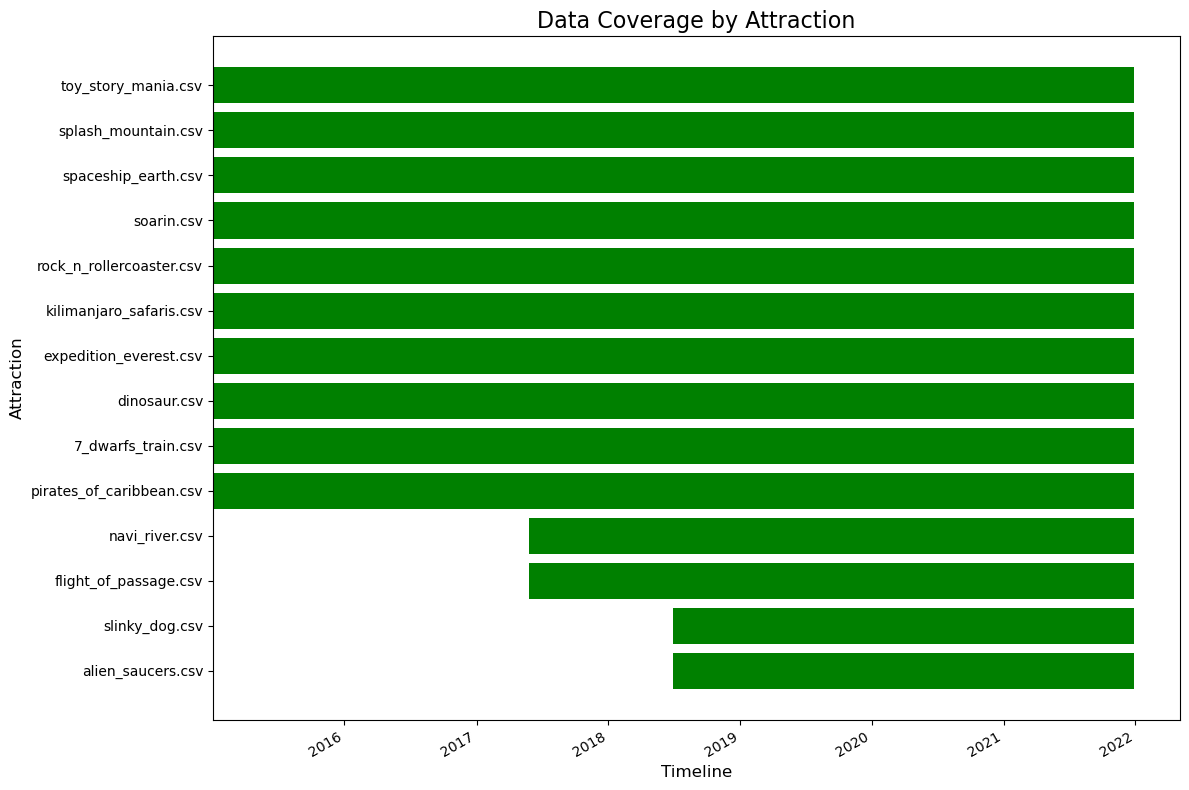

In [15]:
# This just plots the summary to get a quick visual.

summary['start_date'] = pd.to_datetime(summary['start_date'])
summary['end_date'] = pd.to_datetime(summary['end_date'])

summary['duration'] = (summary['end_date'] - summary['start_date']).dt.days
summary = summary.sort_values(by='start_date', ascending=False)

features = summary['feature']
start_dates = summary['start_date']
duration = summary['duration']

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(features, duration, left=start_dates, color='green')
ax.set_title('Data Coverage by Attraction', fontsize=16)
ax.set_xlabel('Timeline', fontsize=12)
ax.set_ylabel('Attraction', fontsize=12)
ax.xaxis_date()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [16]:
# Based on graph above, dropping navi, flight, slinky and alien since their data does not cover the full time span.
# and data during 2019 and 2020 are harder to interpret due to COVID impacts.

keep_columns = ['datetime', '7_dwarfs_train.csv', 'dinosaur.csv',
       'expedition_everest.csv','kilimanjaro_safaris.csv', 'pirates_of_caribbean.csv',
       'rock_n_rollercoaster.csv','soarin.csv',
       'spaceship_earth.csv', 'splash_mountain.csv', 'toy_story_mania.csv']
wait_times_df = pivot_df[keep_columns].copy()
wait_times_df.rename(columns={"7_dwarfs_train.csv":"dwarfs",
        "dinosaur.csv":"dinosaur",
        "expedition_everest.csv":"everest",
        "kilimanjaro_safaris.csv":"kilimanjaro",
        "pirates_of_caribbean.csv":"pirates",
        "rock_n_rollercoaster.csv":"rock_n_roll",
        "soarin.csv":"soarin",
        "spaceship_earth.csv":"spaceship_earth",
        "splash_mountain.csv":"splash",
        "toy_story_mania.csv":"toy_story"
}, inplace = True)

In [17]:
#looking at percentage of missing wait times
missing = pd.concat([wait_times_df.isnull().sum(), 100 * wait_times_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by= 'count', ascending= True)

,count,%
origin_file_attraction,,
datetime,0,0.000000
dwarfs,26116,42.611235
pirates,29557,48.225620
spaceship_earth,29938,48.847265
toy_story,30222,49.310643
rock_n_roll,30488,49.744652
splash,30884,50.390772
soarin,31314,51.092366
everest,32276,52.661978


In [18]:
# removing the hours that the parks are closed.
wait_times_df['datetime'] = pd.to_datetime(wait_times_df['datetime'])
mask = (wait_times_df['datetime'].dt.hour >= 7) | (wait_times_df['datetime'].dt.hour <= 2)
wait_times_operational = wait_times_df.loc[mask].copy()


<Axes: >

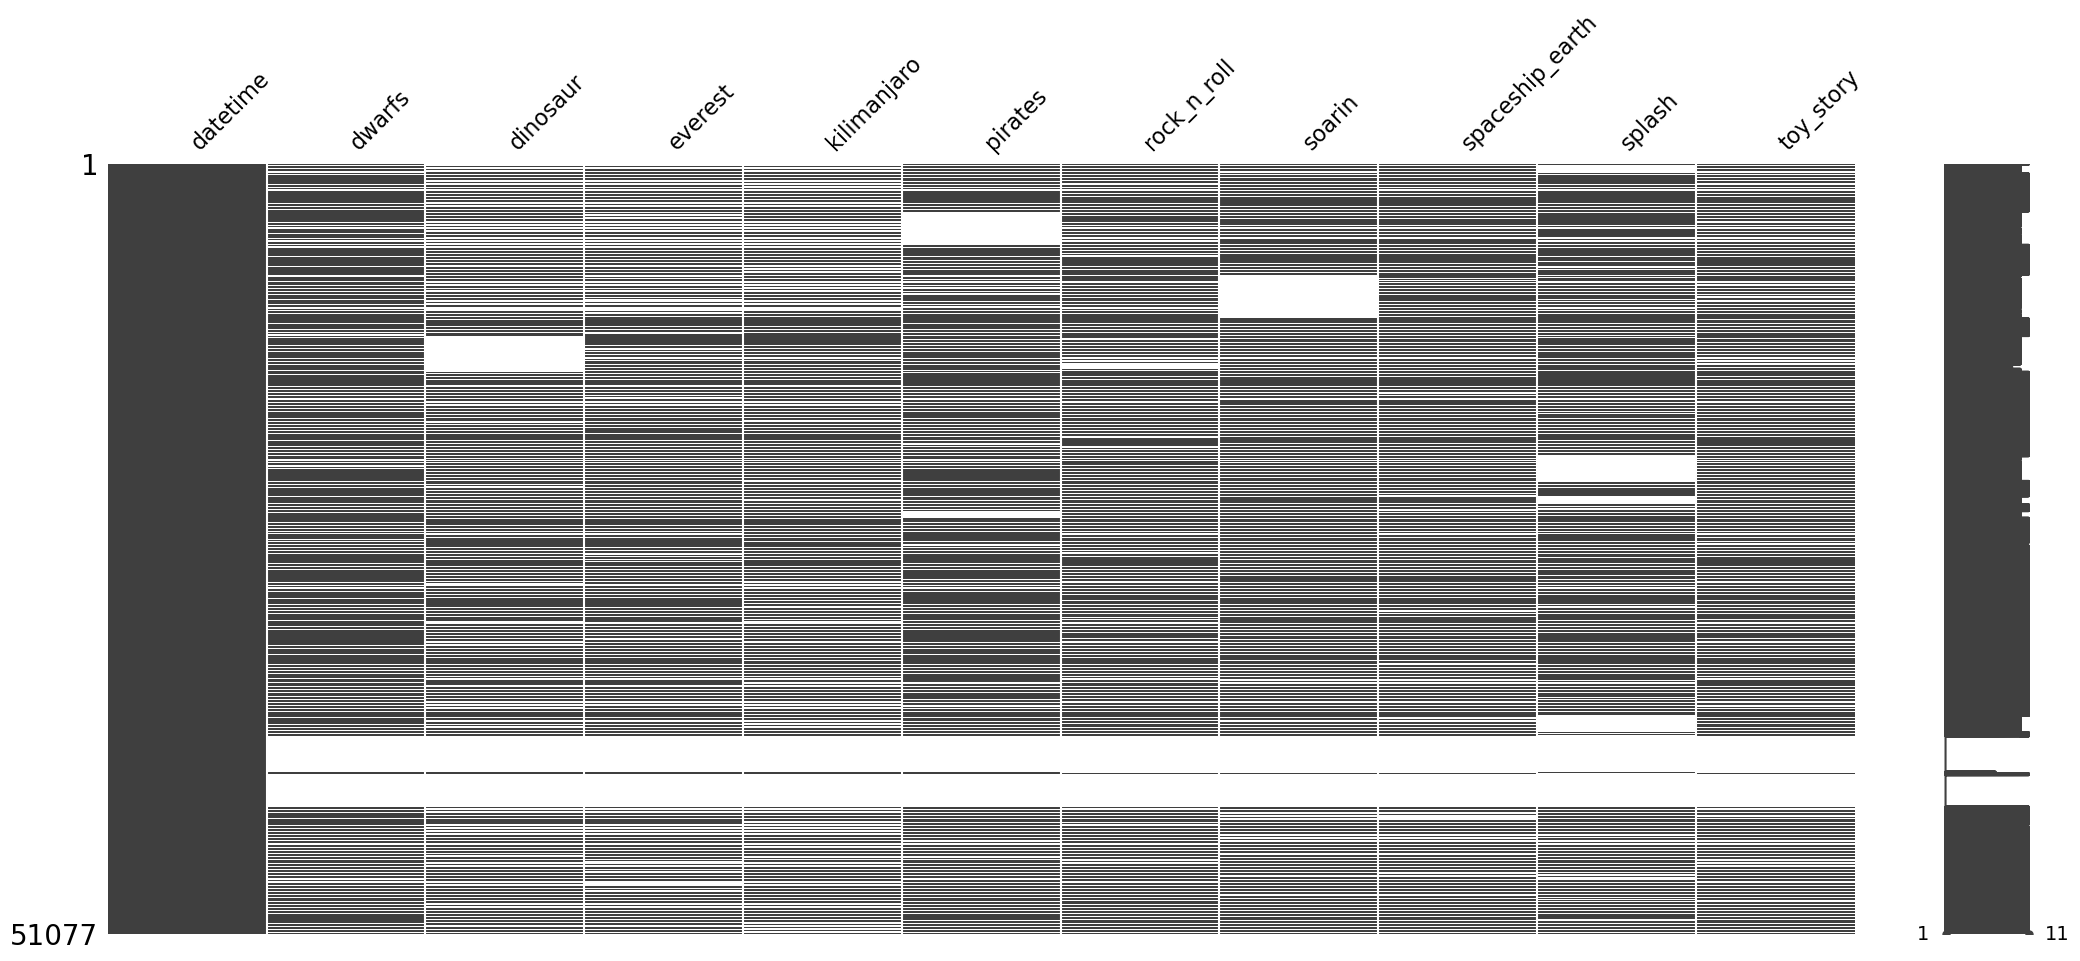

In [19]:
msno.matrix(wait_times_operational)

In [20]:
#  7 dwarfs seems has the most data while pirates and soarin have some gaps. 


In [21]:
#  Running a comparison against years....am guessing COVID is going to affect the 2020 missingness.

wait_times_operational['year'] = pd.DatetimeIndex(wait_times_operational['datetime']).year
cols = ['7_dwarfs', 'dinosaur', 'everest', 'kilimanjaro', 'pirates','rock_n_roll', 'soarin', 'spaceship_earth', 'splash', 'toy_story']
cols = [c for c in cols if c in wait_times_operational.columns]

miss_long = (
    wait_times_operational
    .melt(id_vars='year', value_vars=cols, var_name='column', value_name='val')
    .assign(is_na=lambda d: d['val'].isna().astype(int))
    .groupby(['year','column'], observed=True)['is_na']
    .agg(missing_count='sum', total='count')
    .reset_index()
)
miss_long['missing_pct'] = miss_long['missing_count'] / miss_long['total'] * 100
miss_by_year_pct = miss_long.pivot(index='year', columns='column', values='missing_pct').fillna(0)
miss_by_year_pct

column,dinosaur,everest,kilimanjaro,pirates,rock_n_roll,soarin,spaceship_earth,splash,toy_story
year,,,,,,,,,
2015,45.388516,44.991092,48.677539,48.759764,32.835412,30.176785,30.437166,29.313416,33.534329
2016,59.357923,37.199454,37.295082,26.051913,33.756831,56.530055,30.040984,25.792350,33.333333
2017,32.739726,32.945205,31.589041,28.369863,33.479452,28.890411,29.616438,45.643836,32.657534
2018,33.424658,32.493151,33.191781,29.219178,31.232877,28.726027,30.452055,32.013699,31.780822
2019,35.917808,34.013699,39.013699,26.027397,31.767123,31.479452,33.232877,29.602740,30.465753
2020,78.060109,77.896175,79.658470,74.043716,77.486339,76.366120,76.994536,84.439891,77.158470
2021,42.306630,43.729282,46.906077,32.624309,39.599448,36.961326,39.585635,36.519337,38.176796


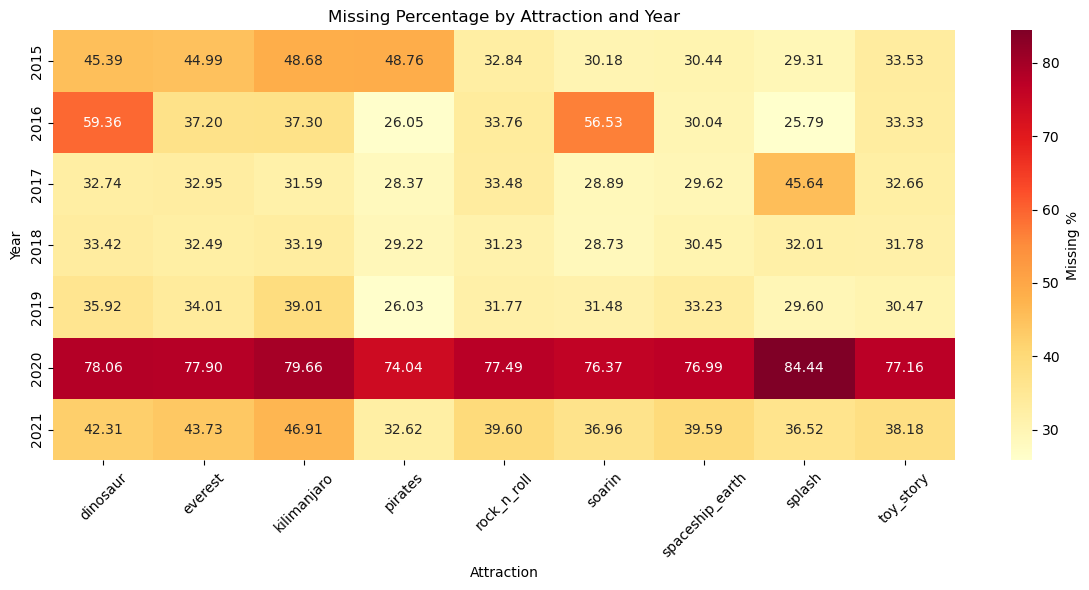

In [22]:
# The below plots the missingness 
plt.figure(figsize=(12, 6))
sns.heatmap(miss_by_year_pct, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Missing %'})
plt.title("Missing Percentage by Attraction and Year")
plt.ylabel("Year")
plt.xlabel("Attraction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# remove helper column and excluding 2020; COVID year is mostly missing.
wait_times_op = wait_times_operational.drop(columns=['year'])
year_col = wait_times_op['datetime'].dt.year
wait_time_sans_2020 = wait_times_op[year_col != 2020].copy()
wait_time_sans_2020.columns

Index(['datetime', 'dwarfs', 'dinosaur', 'everest', 'kilimanjaro', 'pirates',
       'rock_n_roll', 'soarin', 'spaceship_earth', 'splash', 'toy_story'],
      dtype='object', name='origin_file_attraction')

In [24]:
# melting for easier analysis to determine how to handle missing values.
wait_melt = wait_time_sans_2020.melt(id_vars=['datetime'],
                  var_name='origin_file_attraction',
                  value_name='wait_time')

In [25]:
# Associating attractions with the park they are locatd in.

parks = {
    'dwarfs': 'Magic Kingdom',
    'alien_saucers': "Hollywood Studios",
    'dinosaur': "Animal Kingdom",
    'everest': "Animal Kingdom",
    'flight_of_passage': "Animal Kingdom",
    'kilimanjaro': "Animal Kingdom",
    'navi_river': "Animal Kingdom",
    'pirates': "Magic Kingdom",
    'rock_n_roll': "Hollywood Studios",
    'slinky_dog': "Hollywood Studios",
    'soarin': "EPCOT",
    'spaceship_earth': "EPCOT",
    'splash': "Magic Kingdom",
    'toy_story': "Hollywood Studios"
}
wait_melt['parks'] = wait_melt['origin_file_attraction'].map(parks)
wait_melt = wait_melt.rename(columns = {'origin_file_attraction': 'attraction'})

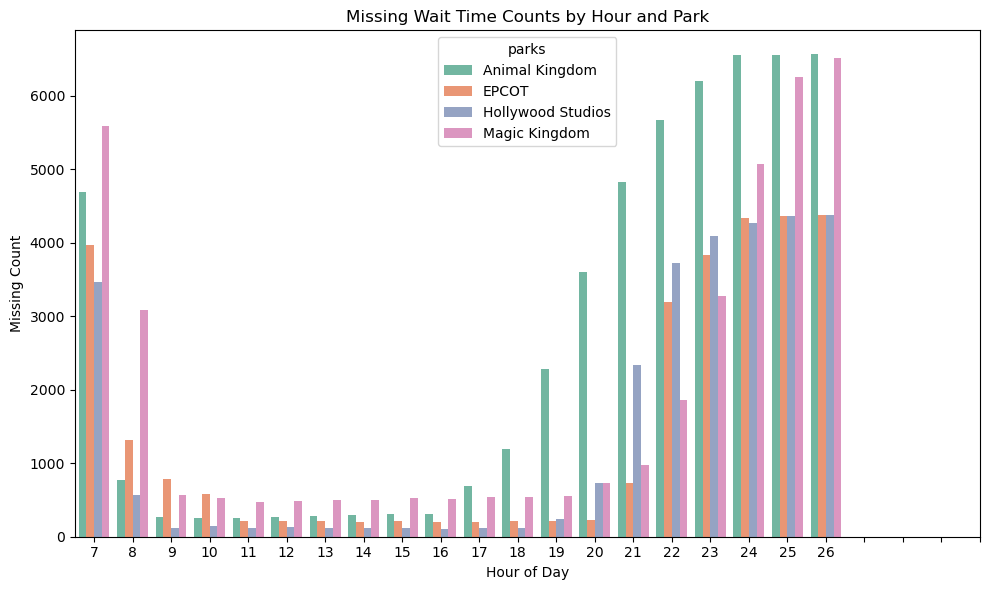

In [26]:
# extracting the hour; lambda the park hours that exceed 00:00 for inclusion in the same day

wait_melt['hour'] = wait_melt['datetime'].dt.hour.map(lambda h: h + 24 if h in [0, 1, 2] else h)
wait_melt['is_missing'] = wait_melt['wait_time'].isna().astype(int)

# Group by hour and park
missing_by_hour = (
    wait_melt.groupby(['hour', 'parks'])['is_missing']
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=missing_by_hour, x='hour', y='is_missing', hue='parks', palette='Set2')
plt.title('Missing Wait Time Counts by Hour and Park')
plt.xlabel('Hour of Day')
plt.ylabel('Missing Count')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

 Seems like the missing data is mostly caused from the open/closing times of the parks...gonna look at NAs by open/
close times of the parks.

In [27]:
#noramlizing date; selecting columns and order
wait_melt['date'] = pd.to_datetime(wait_melt['datetime']).dt.normalize()
wait_melt=wait_melt[['date','datetime','hour','attraction','wait_time','parks']]


In [28]:
#looking at the percentage of missing data.
missing = pd.concat([wait_melt.isnull().sum(), 100 * wait_melt.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by= 'count', ascending= True)


,count,%
date,0,0.000000
datetime,0,0.000000
hour,0,0.000000
attraction,0,0.000000
parks,0,0.000000
wait_time,149861,34.248463


In [29]:
wait_melt.shape

(437570, 6)

In [30]:
#34% is still a high percentage of missing wait times; however even if just drop the data, I will still have over 200,000 
# observations.
wait = wait_melt.dropna()


In [31]:
'''This function will give some further data points to look at based on the wait times.  It adds a column for to show
what the previous hour wait time per attraction was, a column providing the previous hour wait time park_average and
a third column to show the park wide average or each observed hour.'''

def lag_avg_waits(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df.sort_values(['parks', 'attraction', 'datetime'], inplace=True)

    df['wait_lag'] = (df.groupby(['parks', 'attraction'])['wait_time']  # lag per hour per attraction
                      .shift(1))  
    
    park_hourly_avg = (df.groupby(['parks', 'datetime'])['wait_time']  # park_average wait
        .mean().rename('park_avg_wait').reset_index())
    
    park_hourly_avg['park_avg_wait_lag'] = (park_hourly_avg # park_average lag
        .groupby('parks')['park_avg_wait'].shift(1))
    
    df = df.merge(park_hourly_avg, on=['parks', 'datetime'], how='left')
    
    return df


In [32]:
wait_lag = lag_avg_waits(wait)

In [33]:
wait_lag.columns

Index(['date', 'datetime', 'hour', 'attraction', 'wait_time', 'parks',
       'wait_lag', 'park_avg_wait', 'park_avg_wait_lag'],
      dtype='object')

In [34]:
wait_lag.isna().sum()

date                  0
datetime              0
hour                  0
attraction            0
wait_time             0
parks                 0
wait_lag             10
park_avg_wait         0
park_avg_wait_lag     9
dtype: int64

In [35]:
# i think that that wait times nas are from the opening times...
columns = ['wait_lag', 'park_avg_wait', 'park_avg_wait_lag']
na_times = {}
for col in columns:
    na_rows = wait_lag[wait_lag[col].isna()]
    na_times[col] = na_rows['hour'].tolist()

na_times

{'wait_lag': [7, 7, 7, 7, 7, 7, 7, 7, 10, 7],
 'park_avg_wait': [],
 'park_avg_wait_lag': [7, 7, 7, 7, 7, 7, 7, 7, 7]}

In [36]:
#filling the na since these are the opening times and the lag before truly is 0
wait_clean = wait_lag.fillna(0)

In [37]:
wait_clean['wait_lag'] = wait_clean['wait_lag'].astype(int)
wait_clean['park_avg_wait'] = wait_clean['park_avg_wait'].astype(int)
wait_clean['park_avg_wait_lag'] = wait_clean['park_avg_wait_lag'].astype(int)

In [38]:
wait_clean.describe()

,date,datetime,hour,wait_time,wait_lag,park_avg_wait,park_avg_wait_lag
count,287709,287709,287709.000000,287709.0,287709.000000,287709.000000,287709.000000
mean,2018-03-01 03:49:10.593829376,2018-03-01 18:15:10.582567424,14.602585,41.530706,41.529841,41.244278,41.224532
min,2015-01-01 00:00:00,2015-01-01 07:00:00,7.000000,-9217.0,-9217.000000,-3065.000000,-3065.000000
25%,2016-07-24 00:00:00,2016-07-24 09:00:00,11.000000,17.0,17.000000,22.000000,22.000000
50%,2018-01-10 00:00:00,2018-01-10 13:00:00,14.000000,36.0,36.000000,38.000000,38.000000
75%,2019-06-14 00:00:00,2019-06-14 15:00:00,18.000000,58.0,58.000000,57.000000,57.000000
max,2021-12-28 00:00:00,2021-12-28 23:00:00,26.000000,8266.0,8266.000000,4164.000000,4164.000000
std,NaN,NaN,4.233335,38.252032,38.252520,28.871801,28.375301


In [39]:
# need to remove the oultiers 
cols_to_check = ['wait_time','wait_lag','park_avg_wait','park_avg_wait_lag']

mask = ((wait_clean[cols_to_check] >= 0) & (wait_clean[cols_to_check] <= 270)).all(axis=1)
wait_clean = wait_clean[mask].reset_index(drop = True)
wait_clean.describe()


,date,datetime,hour,wait_time,wait_lag,park_avg_wait,park_avg_wait_lag
count,287694,287694,287694.000000,287694.0,287694.000000,287694.000000,287694.000000
mean,2018-03-01 04:17:50.337233408,2018-03-01 18:43:50.219608064,14.602564,41.530939,41.530171,41.246220,41.216244
min,2015-01-01 00:00:00,2015-01-01 07:00:00,7.000000,0.0,0.000000,0.000000,0.000000
25%,2016-07-24 00:00:00,2016-07-24 09:00:00,11.000000,17.0,17.000000,22.000000,22.000000
50%,2018-01-10 00:00:00,2018-01-10 14:00:00,14.000000,36.0,36.000000,38.000000,38.000000
75%,2019-06-14 00:00:00,2019-06-14 15:00:00,18.000000,58.0,58.000000,57.000000,57.000000
max,2021-12-28 00:00:00,2021-12-28 23:00:00,26.000000,270.0,263.000000,211.000000,211.000000
std,NaN,NaN,4.233295,30.486777,30.485309,24.792526,24.895097


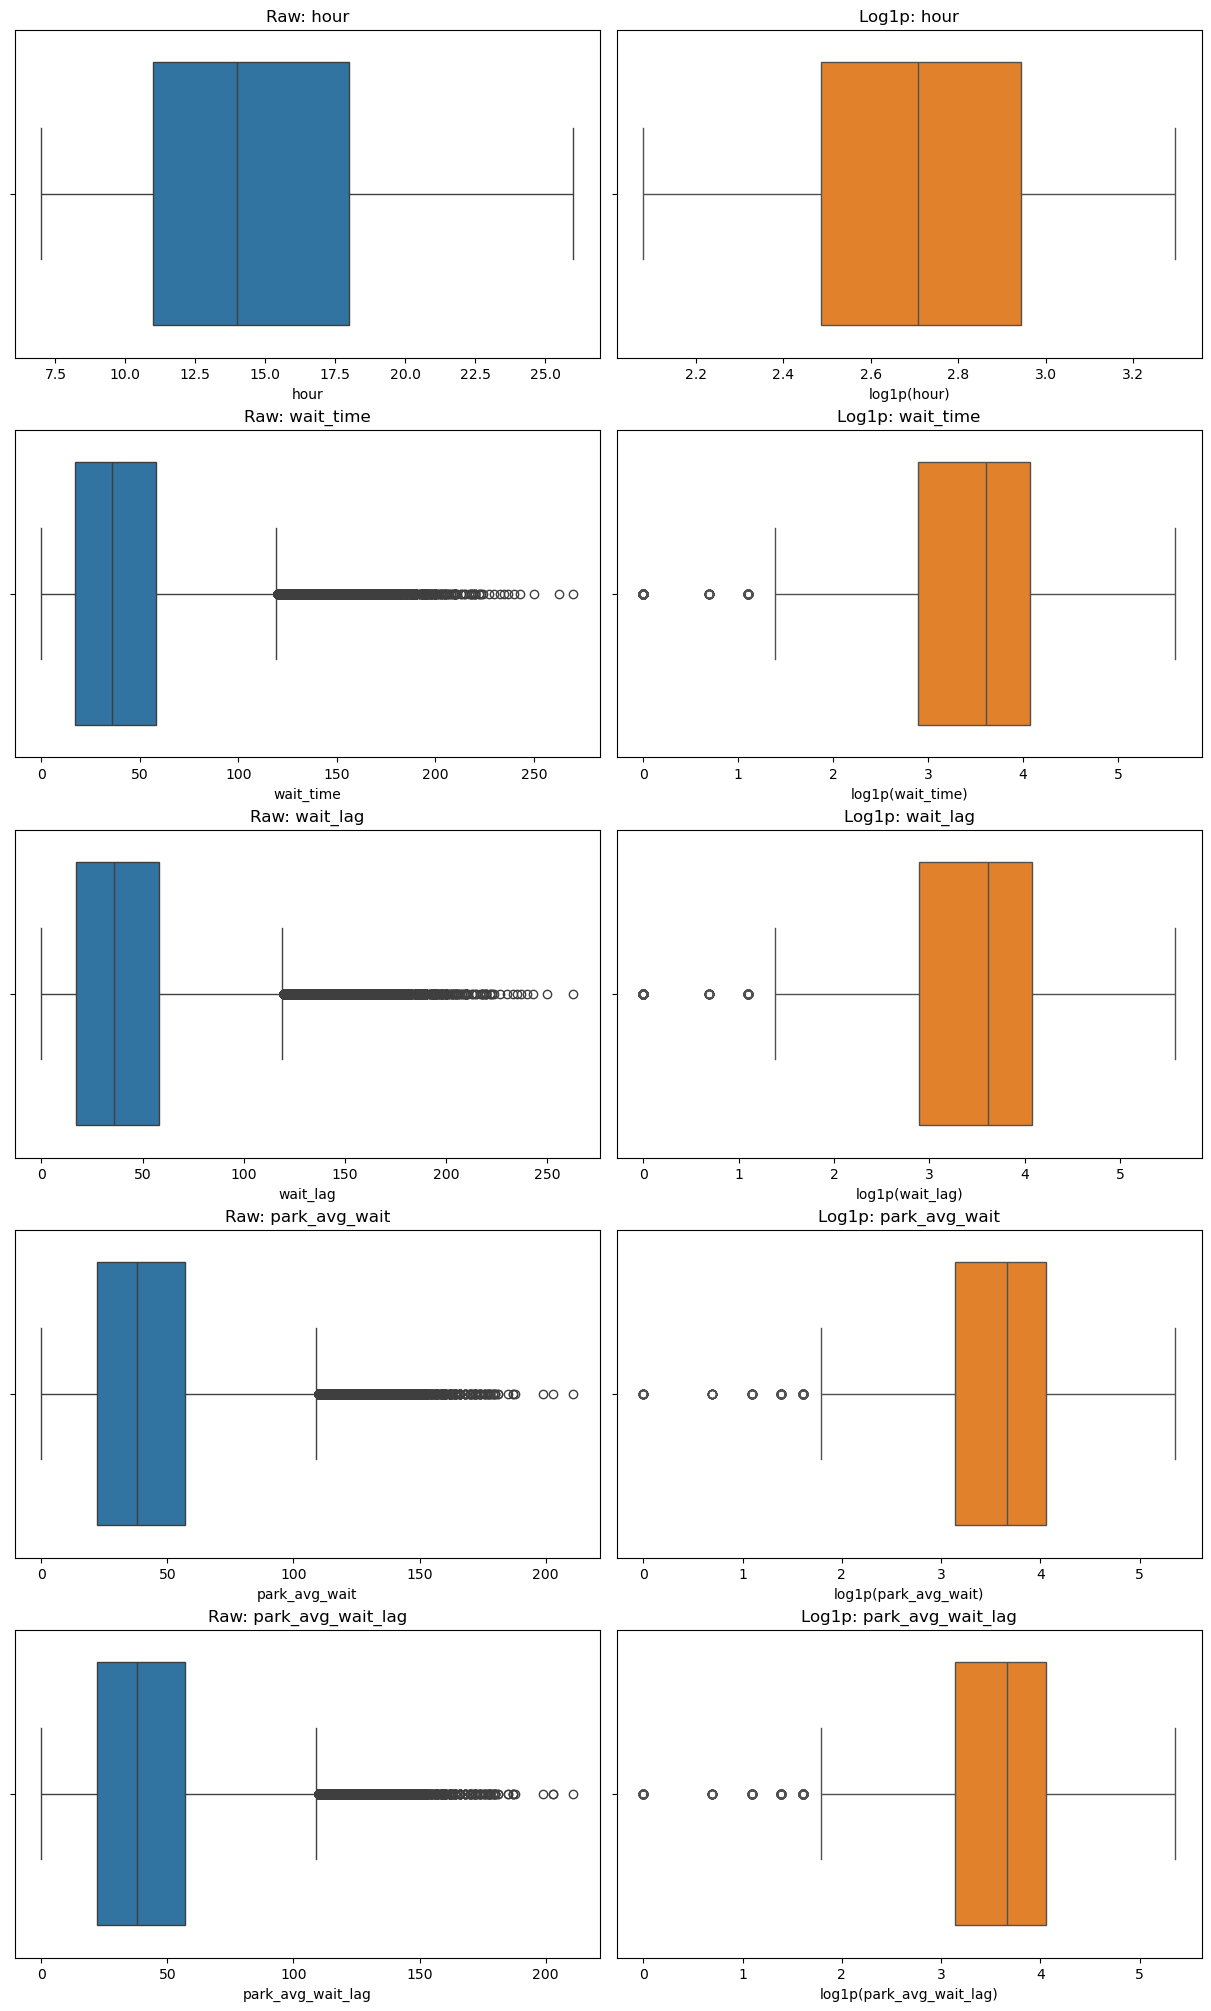

In [40]:
#  taking a look at the numeric columns for raw and log-t distribution
cols = wait_clean.select_dtypes(include='number').columns.drop('index', errors='ignore').tolist()

n_pairs = len(cols)
n_cols = 2  # raw and log1p per row
fig, axes = plt.subplots(n_pairs, n_cols, figsize=(12, 4 * n_pairs), constrained_layout=True)

if n_pairs == 1:
    axes = np.array([axes])  # keep indexing consistent

for i, col in enumerate(cols):
    ax_raw = axes[i, 0]
    ax_log = axes[i, 1]

    # raw boxplot
    sns.boxplot(x=wait_clean[col].dropna(), ax=ax_raw, color='C0')
    ax_raw.set_title(f'Raw: {col}')
    ax_raw.set_xlabel(col)

    # log1p boxplot; handle non-positive values gracefully
    vals = wait_clean[col].dropna()
    if (vals < 0).any():
        # shift to make positive before log1p if negatives are meaningful; otherwise warn/skip
        shift = -vals.min() + 1e-6
        vals_shifted = vals + shift
        sns.boxplot(x=np.log1p(vals_shifted), ax=ax_log, color='C1')
        ax_log.set_xlabel(f'log1p({col} + {shift:.0f})')
    else:
        sns.boxplot(x=np.log1p(vals), ax=ax_log, color='C1')
        ax_log.set_xlabel(f'log1p({col})')
    ax_log.set_title(f'Log1p: {col}')

plt.show()


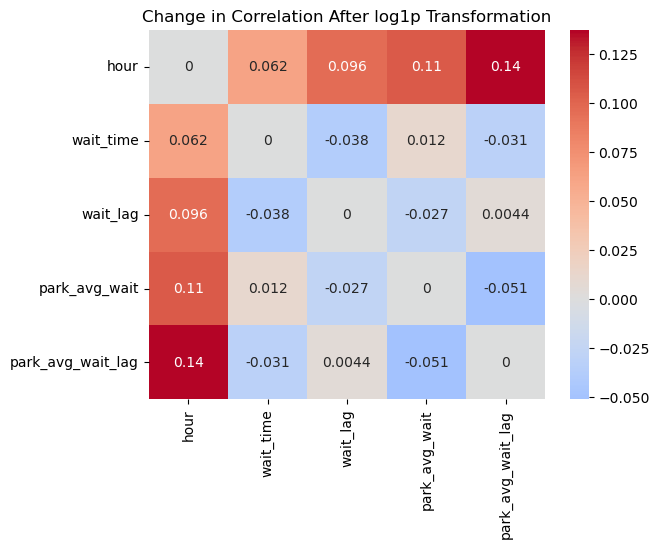

In [41]:
numeric_df = wait_clean.select_dtypes(include='number')
clean_numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

raw_corr = clean_numeric_df.corr()
log_corr = np.log1p(clean_numeric_df.select_dtypes('number')).corr()
diff = log_corr - raw_corr

sns.heatmap(diff, annot=True, cmap='coolwarm', center=0)
plt.title('Change in Correlation After log1p Transformation')
plt.show()


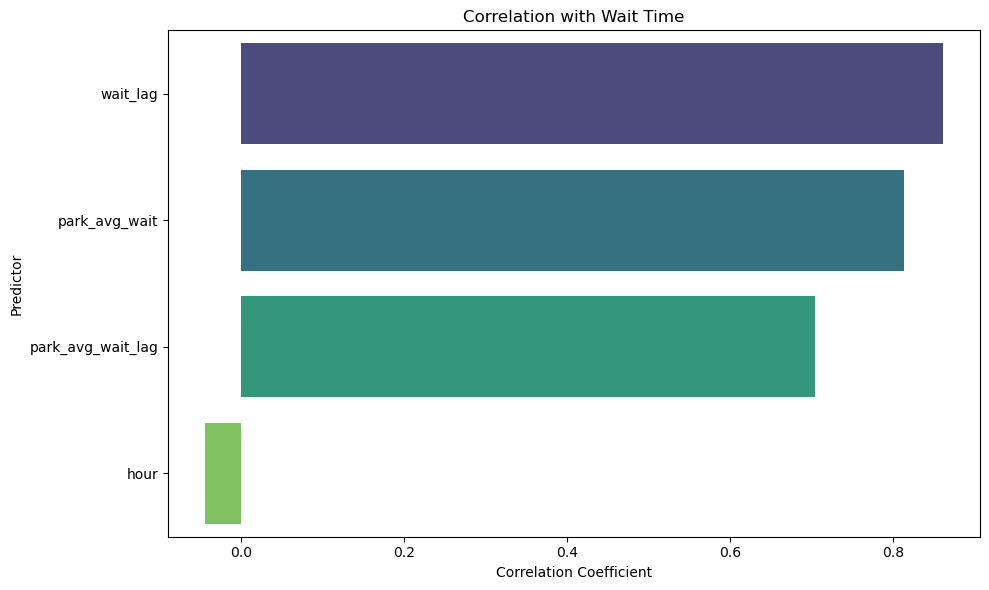

In [42]:
wait_clean_corr = wait_clean.select_dtypes(include='number').corr()['wait_time'].drop('wait_time')
wait_clean_corr = wait_clean_corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=wait_clean_corr.values, y=wait_clean_corr.index, hue=wait_clean_corr.index, palette='viridis', legend=False)
plt.title('Correlation with Wait Time')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()




In [43]:
wait_clean.to_csv('Processed Attraction Dataset/wait_clean.csv')

.

.

Section 3:  Metadata.  Below begins metadata processing. In the provided form, the metadata is listed by day only.  I want to get my
metadata listed by hour to coincide with wait times and weather data.  Accompanying the meta file is a data_dictionary that specifies data types.  
I am importing those so I can implicitly assign types to the columns.

.

.

In [44]:
meta_dict.head()

,Variable Category,Variable Name,Variable Description,Format
0,Main Variables,DATE,Park Day (not actual date stamp of the wait ti...,MM/DD/YYY
1,Pricing Variables,WDW_TICKET_SEASON,Walt Disney World Single Day Price Type,alphanumeric
2,Day Variables,DAYOFWEEK,Day of Week,numeric
3,Day Variables,DAYOFYEAR,Day of Year (0 to 365),numeric
4,Day Variables,WEEKOFYEAR,Week of Year (0 to 53),numeric


In [45]:
meta_dict['Format'].unique()

array(['MM/DD/YYY', 'alphanumeric', 'numeric', 'Boolean', 'HH:MM'],
      dtype=object)

In [46]:
meta_formats =  meta_dict.groupby('Format')['Variable Name'].apply(list).to_dict()

In [47]:
for fmt, cols in meta_formats.items():
    exec(f"{fmt.replace('/', '').replace(':', '').replace(' ', '').lower()}_cols = {cols}")

In [48]:
meta_file.describe()

,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,HOLIDAY,WDWevent,WDWrace,...,HSPRDDN,HSFIREWK,HSSHWNGT,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT
count,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,...,0.0,2079.000000,2079.000000,2079.0,2079.0,0.0,0.0,0.0,0.0,2079.000000
mean,3.995671,181.835498,26.091871,6.514671,2017.414622,7.846561,0.537759,0.102934,0.118807,0.041847,...,NaN,0.783069,1.276094,1.0,0.0,NaN,NaN,NaN,NaN,1.043771
std,2.002520,106.341415,15.198486,3.476534,1.741001,6.889128,1.346722,0.303946,0.323639,0.200288,...,NaN,0.450197,0.620287,0.0,0.0,NaN,NaN,NaN,NaN,0.966478
min,1.000000,0.000000,0.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.000000,0.000000,1.0,0.0,NaN,NaN,NaN,NaN,0.000000
25%,2.000000,89.000000,13.000000,3.000000,2016.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,1.000000,1.000000,1.0,0.0,NaN,NaN,NaN,NaN,0.000000
50%,4.000000,184.000000,26.000000,7.000000,2017.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,1.000000,1.000000,1.0,0.0,NaN,NaN,NaN,NaN,1.000000
75%,6.000000,273.000000,39.000000,10.000000,2019.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,1.000000,2.000000,1.0,0.0,NaN,NaN,NaN,NaN,2.000000
max,7.000000,365.000000,53.000000,12.000000,2021.000000,33.000000,5.000000,1.000000,1.000000,1.000000,...,NaN,2.000000,3.000000,1.0,0.0,NaN,NaN,NaN,NaN,3.000000


In [49]:
meta = meta_file.copy()

In [50]:
"""  This function looks for empty columns and removes them"""
def handle_empty_columns(df, drop=False):
    def is_blank(col):
        return col.isna().all() or (col.astype(str).str.strip() == '').all()
    
    empty_cols = [col for col in df.columns if is_blank(df[col])]
    
    if drop:
        return df.drop(columns=empty_cols)
    else:
        return empty_cols

meta = handle_empty_columns(meta_file, drop = True)

In [51]:
#dropping the weather columns from meta data; weather data obtained separately and 
#and didn't want to mix sources. using meteostat data for both hourly and daily avgs.  Additionally dropping two columns that had no data.
meta_cols = ['WDWMAXTEMP','WDWMINTEMP','WDWMEANTEMP','WEATHER_WDWPRECIP','WEATHER_WDWHIGH', 'WEATHER_WDWLOW','inSession_Central_FL','INSESSION_PLANES',
             'AKeventN']
meta=meta.drop(columns=meta_cols)

In [52]:
# For reference: these are the variable names created associated with each format: 
#                  boolean_cols | numeric_cols | alphanumeric_cols| mmddyyy_cols | hhmm_cols

In [53]:
#the following is to implicitly define the dtype;

meta[boolean_cols] = meta[boolean_cols].astype('int')

existing_numeric = [col for col in numeric_cols if col in meta.columns]
meta[existing_numeric] = meta[existing_numeric].apply(pd.to_numeric, errors='coerce')


existing_alphanumeric = [col for col in alphanumeric_cols if col in meta.columns]
meta[existing_alphanumeric] = meta[existing_alphanumeric].astype('category')

existing_hhmm = [col for col in hhmm_cols if col in meta.columns]
meta[existing_hhmm] = (
    meta[existing_hhmm]
    .apply(pd.to_datetime, format='%H:%M', errors='coerce')
    .apply(lambda x: x.dt.time)
)


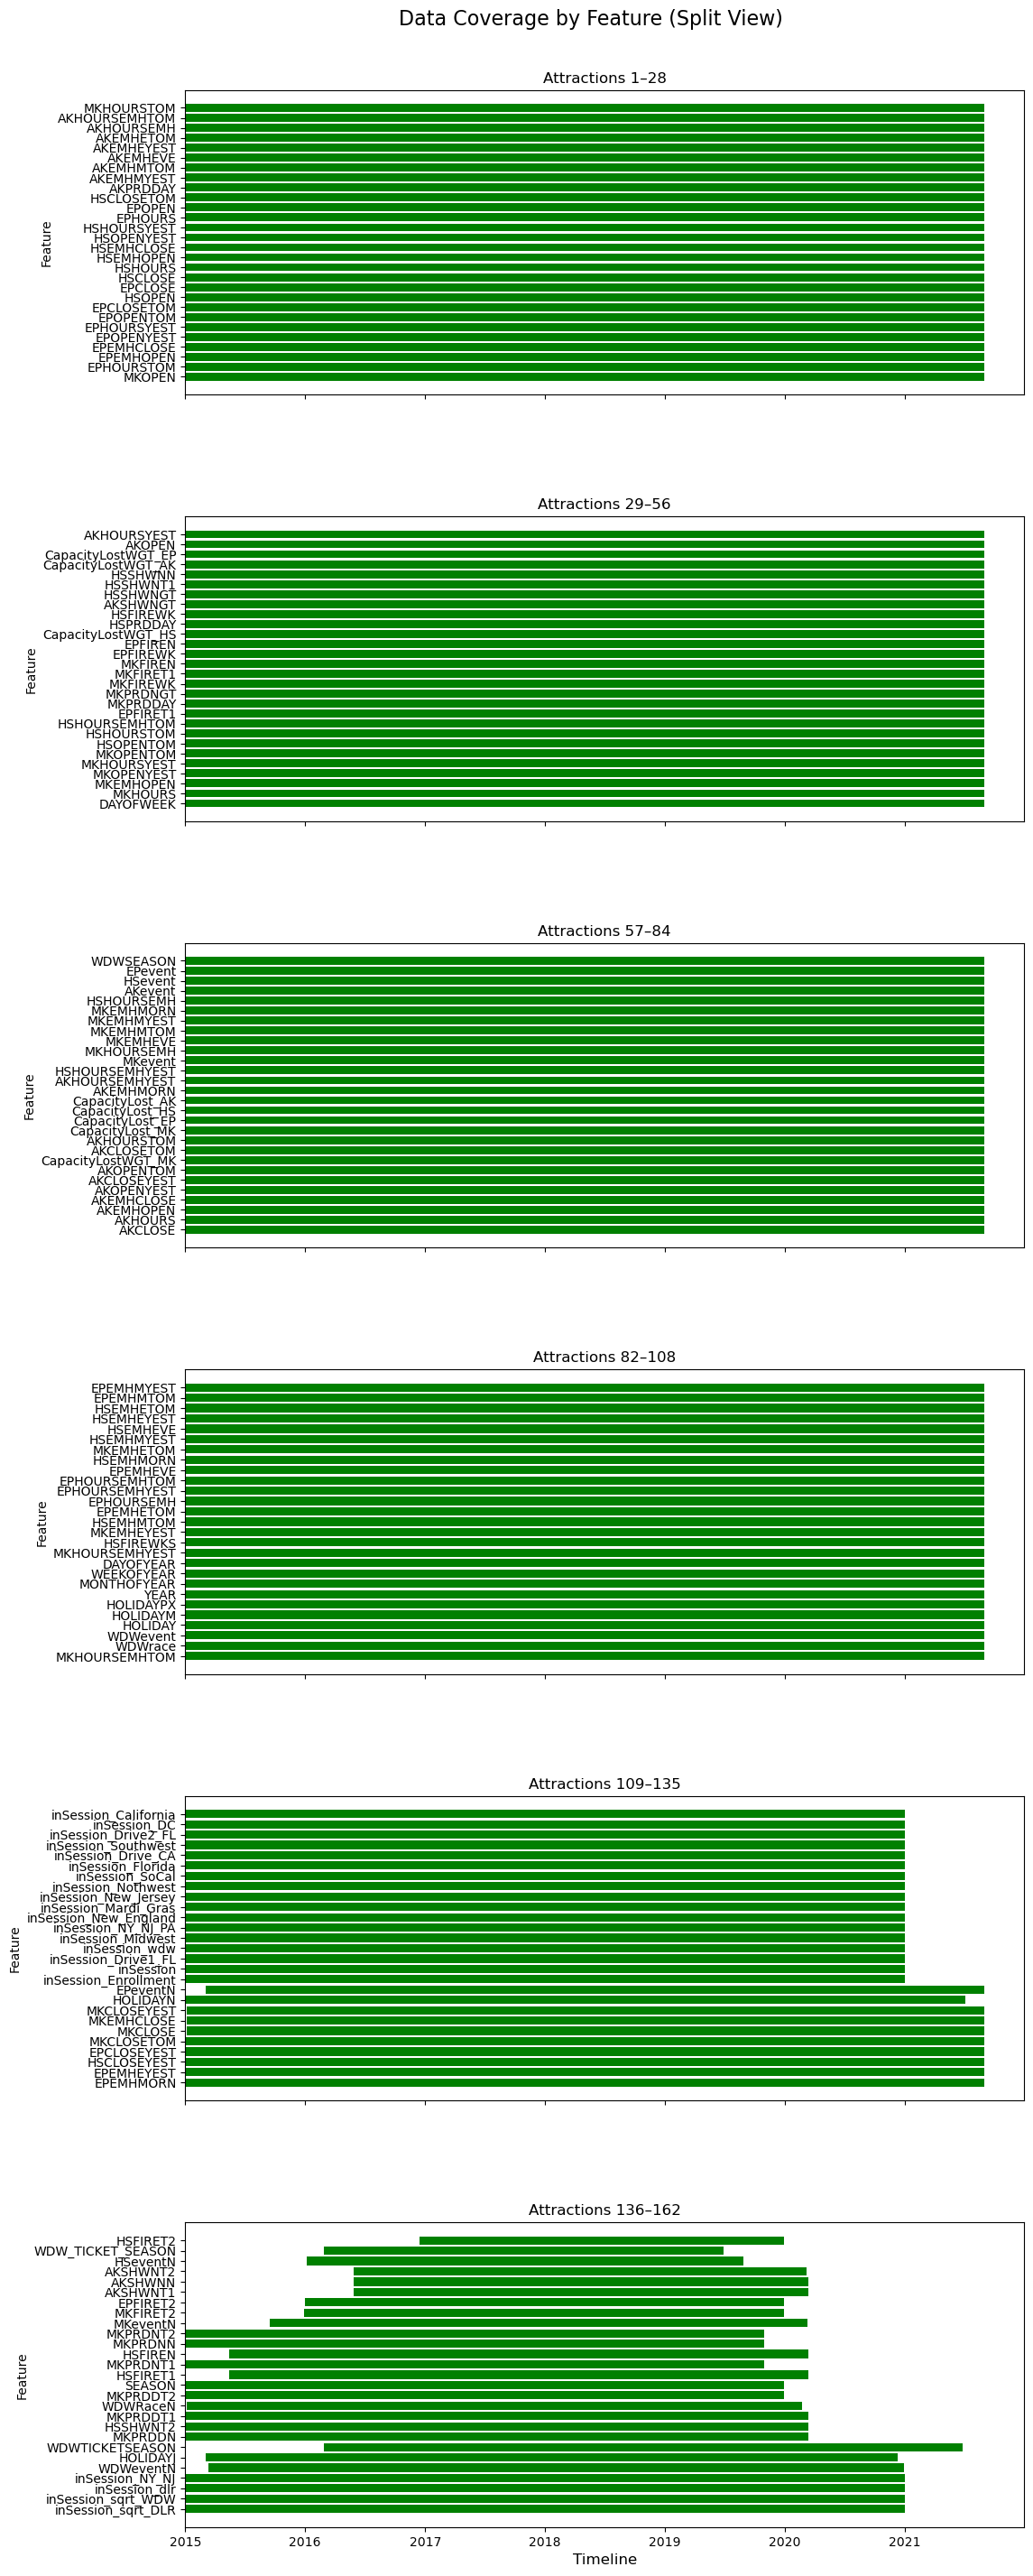

In [54]:
#repurpose sum_attr_data_start_stop(df, datetime_cols) function from attractions

meta_check = sum_attr_data_start_stop(meta, 'DATE') 

meta_check['start_date'] = pd.to_datetime(meta_check['start_date'])
meta_check['end_date'] = pd.to_datetime(meta_check['end_date'])
meta_check['duration'] = (meta_check['end_date'] - meta_check['start_date']).dt.days

meta_check = meta_check.sort_values(by='duration', ascending=False).reset_index(drop=True)


chunks = np.array_split(meta_check, 6)

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 30), sharex=True)

for i, chunk in enumerate(chunks):
    features = chunk['feature']
    start_dates = chunk['start_date']
    duration = chunk['duration']

    axes[i].barh(features, duration, left=start_dates, color='green')
    axes[i].set_title(f'Attractions {i*len(chunk)+1}–{i*len(chunk)+len(chunk)}', fontsize=12)
    axes[i].set_ylabel('Feature', fontsize=10)
    axes[i].xaxis_date()

axes[-1].set_xlabel('Timeline', fontsize=12)
fig.suptitle('Data Coverage by Feature (Split View)', fontsize=16)
fig.subplots_adjust(hspace=0.4, top=0.95, bottom=0.05)

plt.show()


In [55]:
# a lot of data is missing in year 2021.  Since I dropped 2020 from the attraction df, it makes sense to go ahead and drop those years from
#the meta df.  I will drop the year 2020 and  2021 from the final merge data frame.



In [56]:
meta['DATE'] = pd.to_datetime(meta['DATE'], errors='coerce')
meta['DATE'] = meta['DATE'].dt.normalize()


In [57]:
wait_wx = pd.merge(wait_clean, weather, how='left', on='datetime', suffixes=('', '_drop'))


In [58]:
wait_wx_meta = pd.merge(wait_wx, meta, how='left', left_on = 'date', right_on='DATE')

In [59]:
disney_df= wait_wx_meta.copy()

In [60]:
disney_df.to_csv('Processed Attraction Dataset/disney_df.csv')

In [61]:
disney_df.shape

(287694, 182)

In [62]:
disney_df = disney_df[~disney_df['datetime'].dt.year.isin([2020, 2021])]


In [63]:
disney_df.shape

(243339, 182)

In [64]:
disney_df[boolean_cols].isna().sum()

HOLIDAY       0
WDWevent      0
WDWrace       0
MKevent       0
EPevent       0
HSevent       0
AKevent       0
MKEMHMORN     0
MKEMHMYEST    0
MKEMHMTOM     0
MKEMHEVE      0
MKEMHEYEST    0
MKEMHETOM     0
EPEMHMORN     0
EPEMHMYEST    0
EPEMHMTOM     0
EPEMHEVE      0
EPEMHEYEST    0
EPEMHETOM     0
HSEMHMORN     0
HSEMHMYEST    0
HSEMHMTOM     0
HSEMHEVE      0
HSEMHEYEST    0
HSEMHETOM     0
AKEMHMORN     0
AKEMHMYEST    0
AKEMHMTOM     0
AKEMHEVE      0
AKEMHEYEST    0
AKEMHETOM     0
MKPRDNGT      0
dtype: int64

In [65]:
disney_df['DATE'].isna().sum()

0

In [66]:
disney_df[existing_numeric].isna().sum()

DAYOFWEEK         0
DAYOFYEAR         0
WEEKOFYEAR        0
MONTHOFYEAR       0
YEAR              0
HOLIDAYPX         0
HOLIDAYM          0
MKHOURSEMH        0
MKHOURSEMHYEST    0
MKHOURSEMHTOM     0
EPHOURSEMH        0
EPHOURSEMHYEST    0
EPHOURSEMHTOM     0
HSHOURSEMH        0
HSHOURSEMHYEST    0
HSHOURSEMHTOM     0
AKHOURSEMH        0
AKHOURSEMHYEST    0
AKHOURSEMHTOM     0
MKHOURS           0
MKHOURSYEST       0
MKHOURSTOM        0
EPHOURS           0
EPHOURSYEST       0
EPHOURSTOM        0
HSHOURS           0
HSHOURSYEST       0
HSHOURSTOM        0
AKHOURS           0
AKHOURSYEST       0
AKHOURSTOM        0
MKPRDDAY          0
MKFIREWK          0
EPFIREWK          0
HSPRDDAY          0
HSFIREWK          0
HSSHWNGT          0
HSFIREWKS         0
AKPRDDAY          0
AKSHWNGT          0
dtype: int64

In [67]:
disney_df[existing_alphanumeric].isna().sum()


WDW_TICKET_SEASON     78405
SEASON                    0
HOLIDAYN             217329
WDWTICKETSEASON       78405
WDWRaceN             233241
WDWeventN            217669
WDWSEASON                 0
MKeventN             176376
EPeventN             109354
HSeventN             216271
HOLIDAYJ             237969
MKPRDDN                   1
MKPRDNN              150794
MKFIREN                1351
EPFIREN                 431
HSFIREN               38769
HSSHWNN                1353
AKSHWNN               87699
dtype: int64

In [68]:
# i have the shows listed as categories.  the missing values are all from the categories.  gonna leave as is
# to start running some correlations across all data.


In [69]:
disney_df[existing_numeric].astype(int)
disney_df[boolean_cols].astype(int)
disney_df.dtypes.value_counts()


float64           80
object            69
int32              7
datetime64[ns]     4
Float64            2
category           2
category           2
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
int64              1
category           1
category           1
Int64              1
category           1
Name: count, dtype: int64

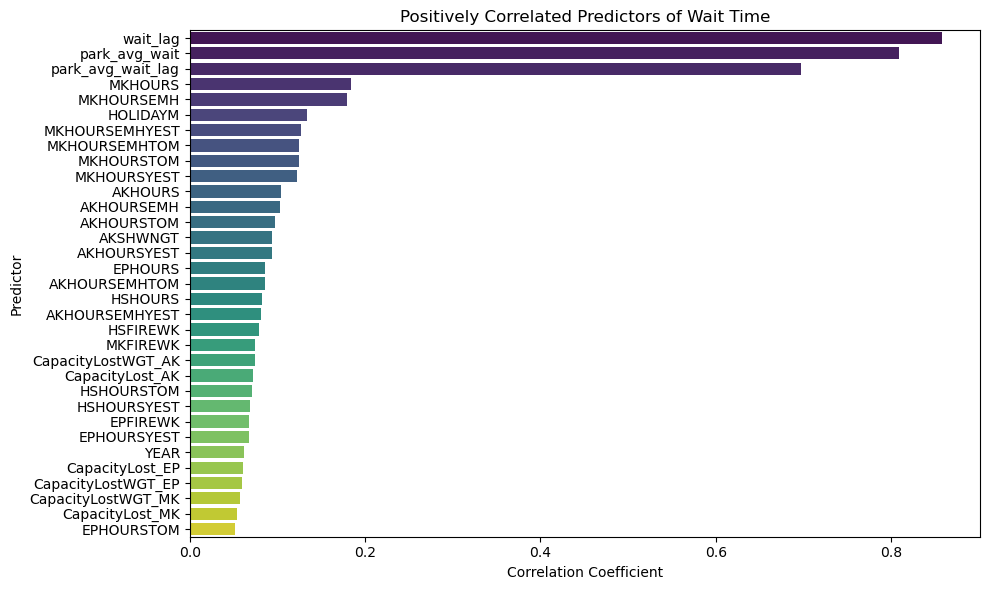

In [70]:
disney_df_corr = (
    disney_df.select_dtypes(include='number')
    .corr()['wait_time']
    .drop('wait_time')
)

positive_corr = disney_df_corr[disney_df_corr > 0.05].sort_values(ascending=False) # gonna try anything over .05; realize I want values closer to 1

plt.figure(figsize=(10, 6))
sns.barplot(x=positive_corr.values, y=positive_corr.index, hue=positive_corr.index, palette='viridis', legend=False)
plt.title('Positively Correlated Predictors of Wait Time')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()



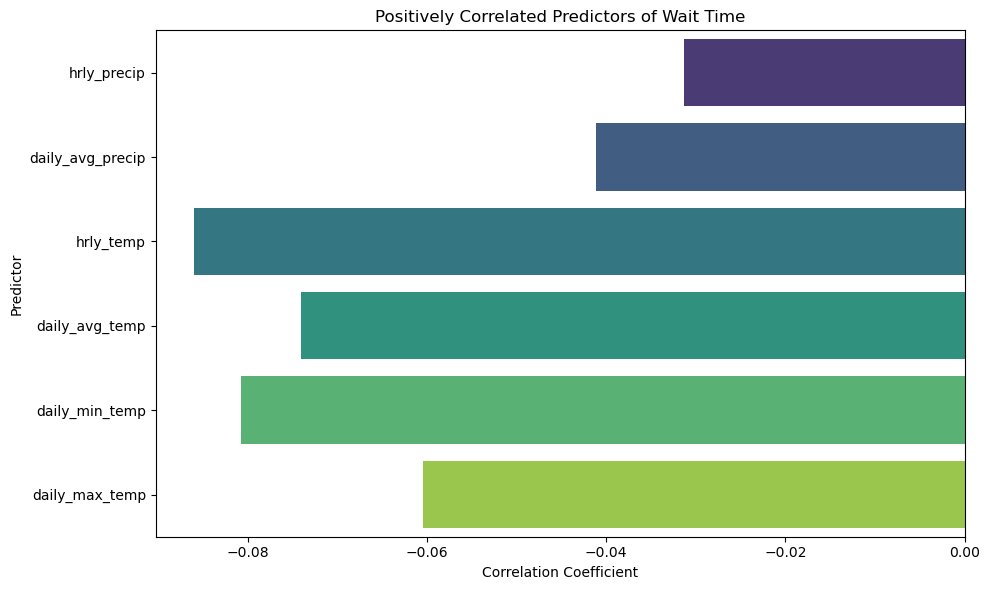

In [71]:
# looking specifically at weather...would think those would have a big impact.

subset = disney_df[['wait_time', 'hrly_precip', 'daily_avg_precip', 'hrly_temp', 'daily_avg_temp', 'daily_min_temp', 'daily_max_temp']]
correlations = subset.corr()['wait_time'].drop('wait_time')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, hue=correlations.index, palette='viridis', legend=False)
plt.title('Positively Correlated Predictors of Wait Time')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()


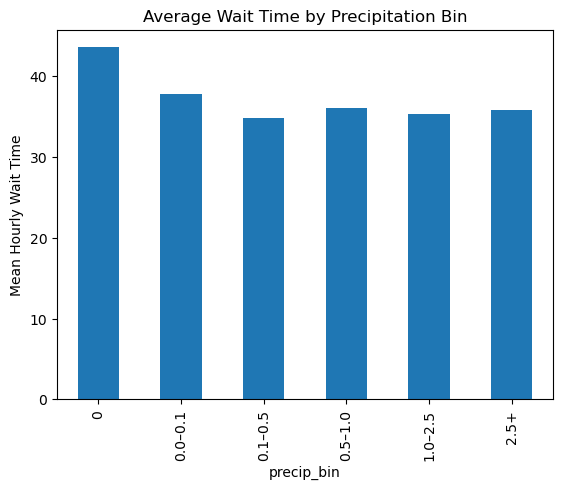

In [72]:
# will try binning....

bins = [0, 0.1, 0.5, 1.0, 2.5, 5, disney_df['hrly_precip'].max()]
labels = ['0', '0.0–0.1', '0.1–0.5', '0.5–1.0', '1.0–2.5', '2.5+']

disney_df['precip_bin'] = pd.cut(disney_df['hrly_precip'], bins=bins, labels=labels, include_lowest=True)
bin_summary = disney_df.groupby('precip_bin', observed=True)['wait_time'].agg(['mean','count']).reset_index()

bin_summary.plot(x='precip_bin', y='mean', kind='bar', legend=False)
plt.ylabel('Mean Hourly Wait Time')
plt.title('Average Wait Time by Precipitation Bin')
plt.show()

In [73]:
# Binning precipitation shows that when there is rain, there is a slight decrease in wait times.

In [74]:
# will try same on temperatures

temp_bins = [30, 50, 60, 70, 80, 90, disney_df['hrly_temp'].max()]
temp_labels = ['<50°F', '50–60°F', '60–70°F', '70–80°F', '80–90°F', '90°F+']

disney_df['temp_bin'] = pd.cut(
    disney_df['hrly_temp'],
    bins=temp_bins,
    labels=temp_labels,
    include_lowest=True
)
temp_bin_summary = disney_df.groupby('temp_bin', observed=True)['wait_time'].agg(['mean','count']).reset_index()


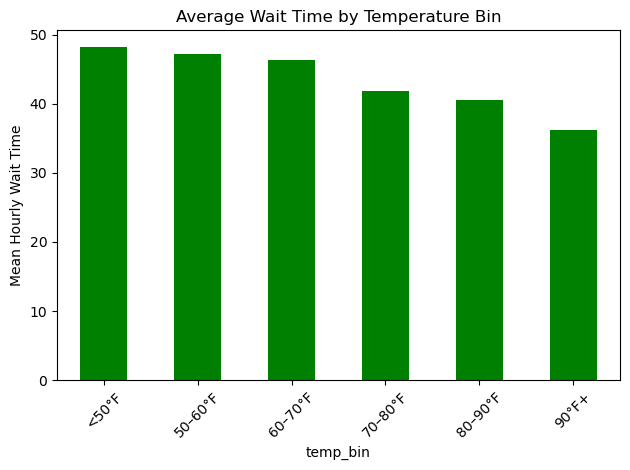

In [75]:
temp_bin_summary.plot(x='temp_bin', y='mean', kind='bar', legend=False, color='green')
plt.ylabel('Mean Hourly Wait Time')
plt.title('Average Wait Time by Temperature Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [76]:
# Binning temperatures shows that there is greater drop in wait times when the temperature rises.

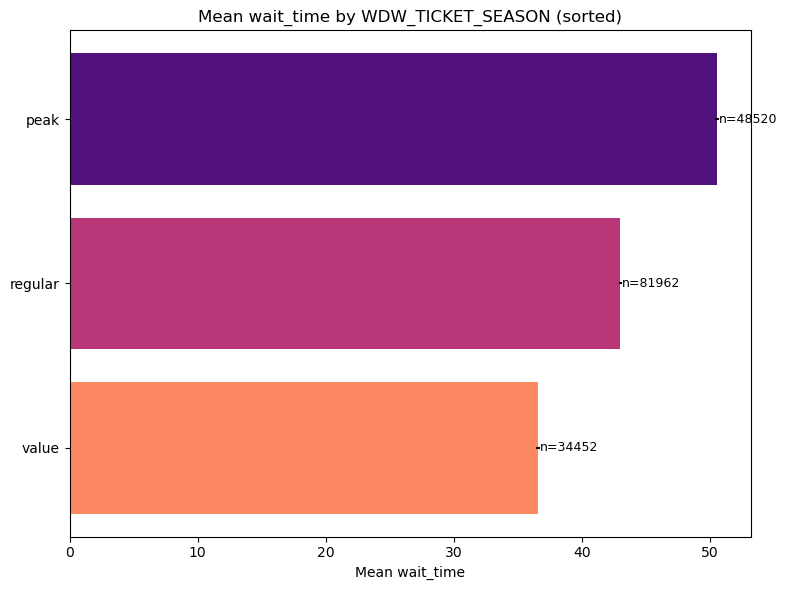

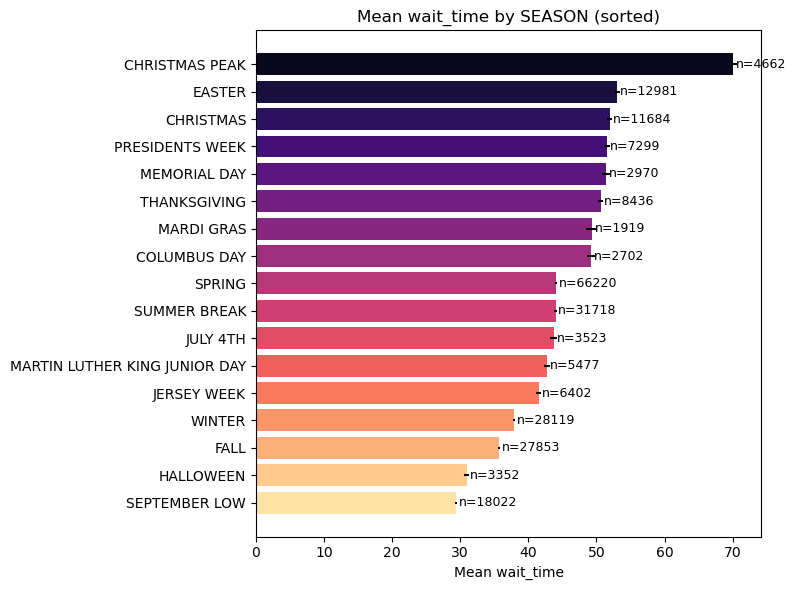

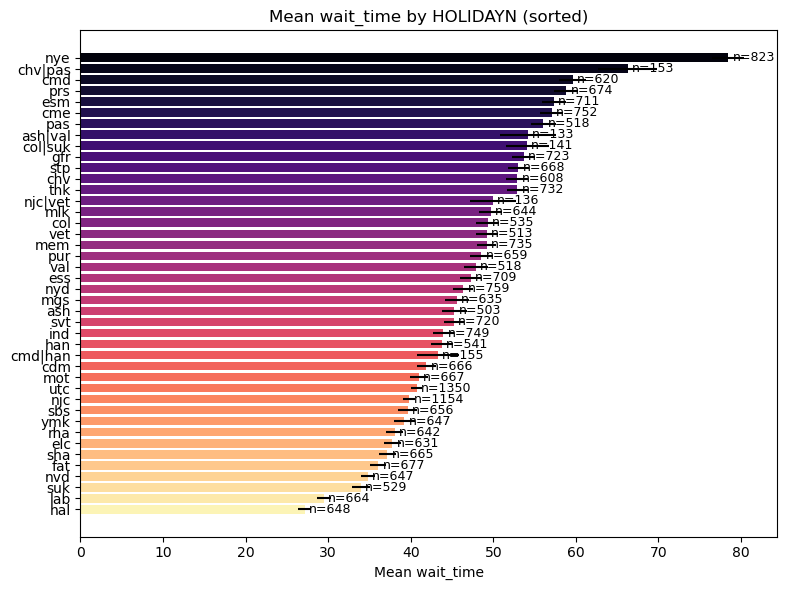

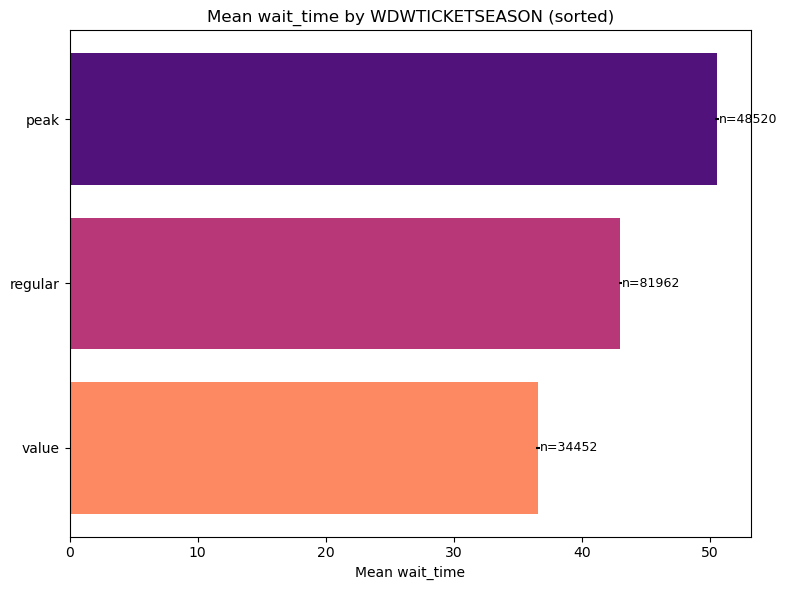

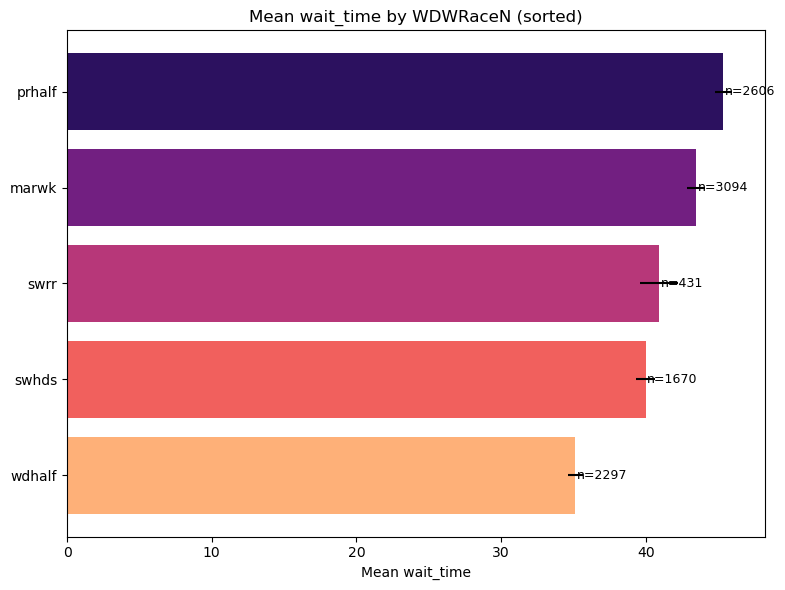

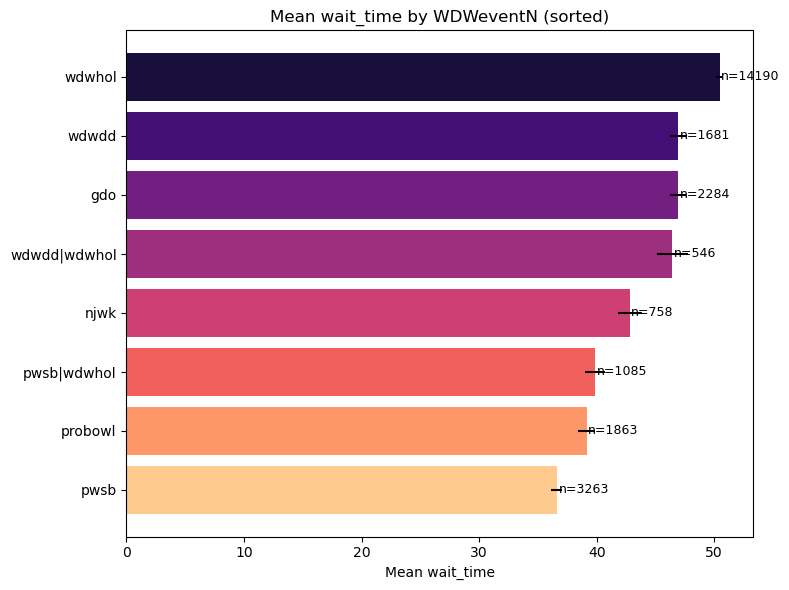

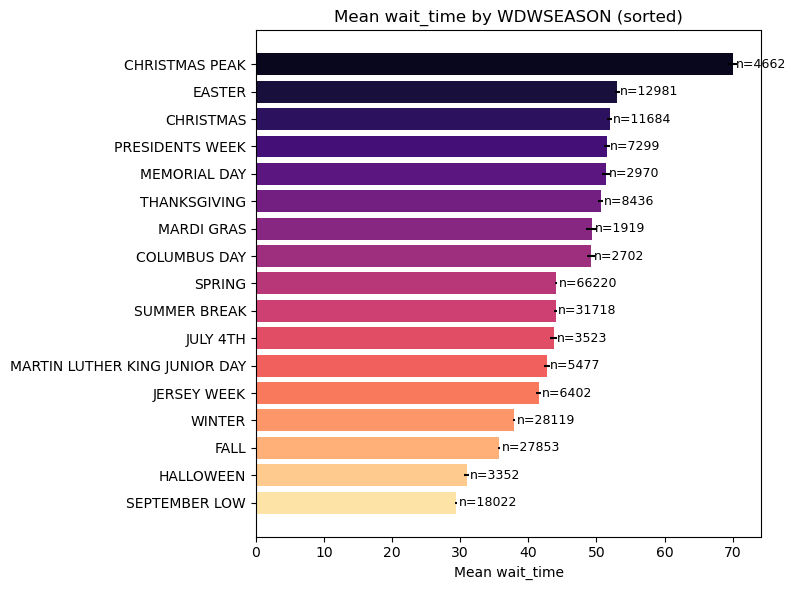

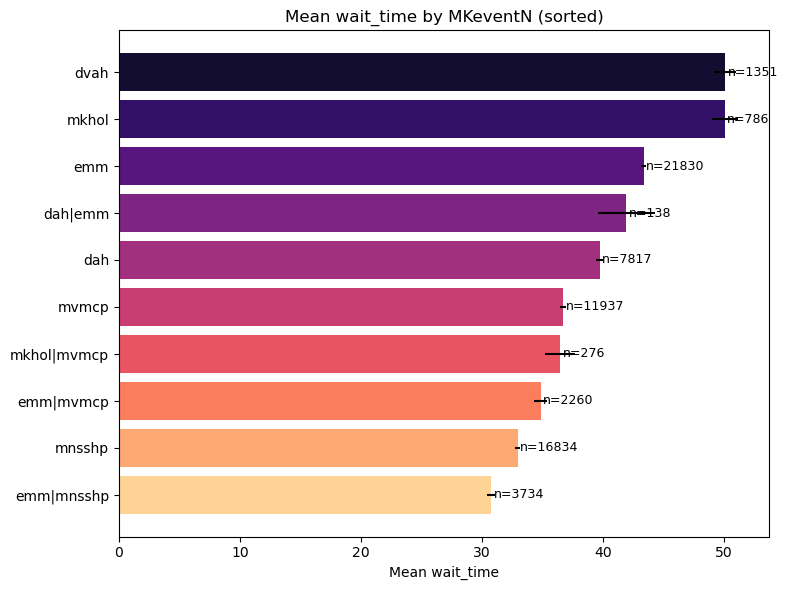

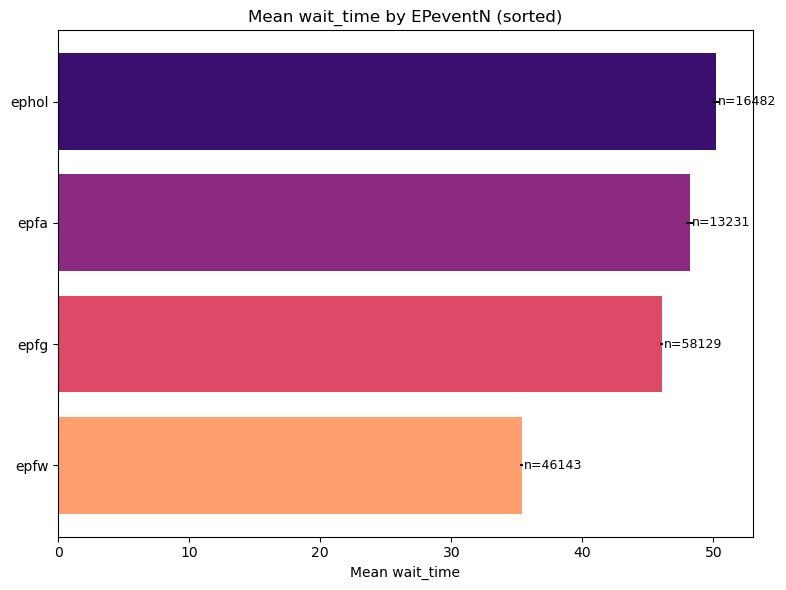

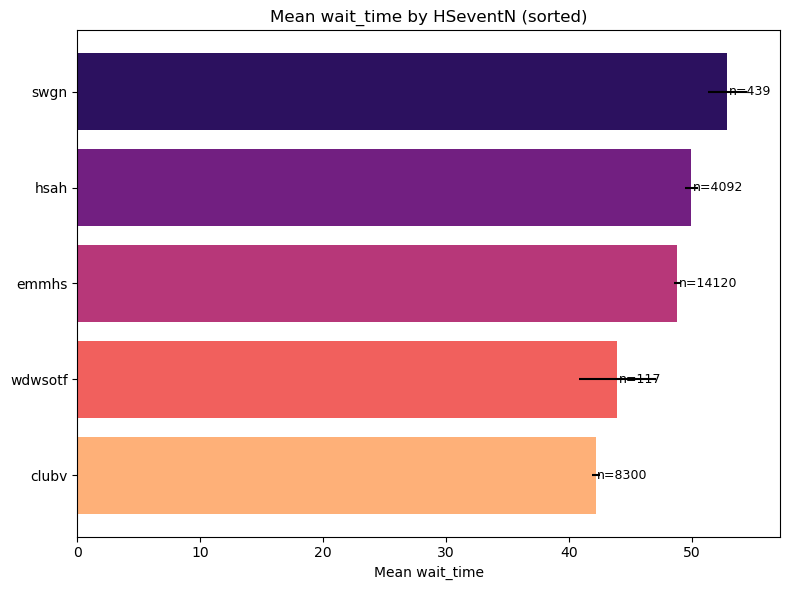

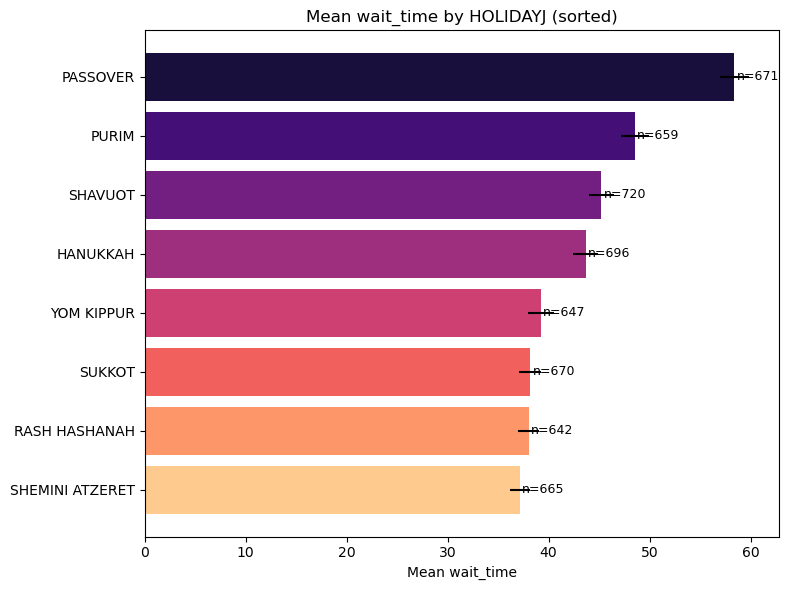

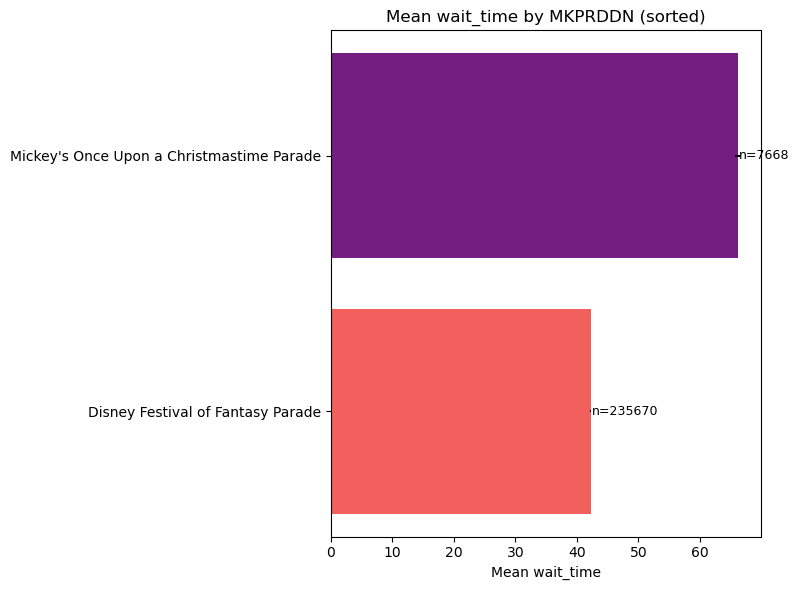

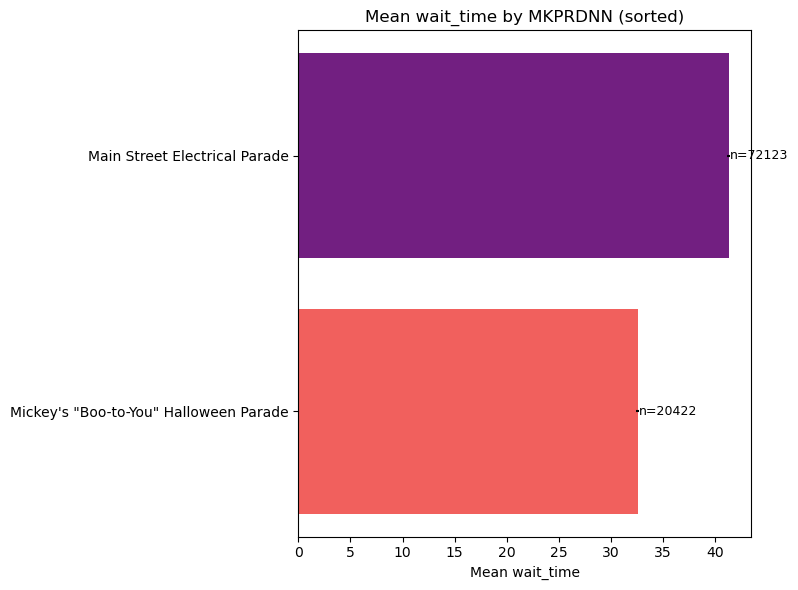

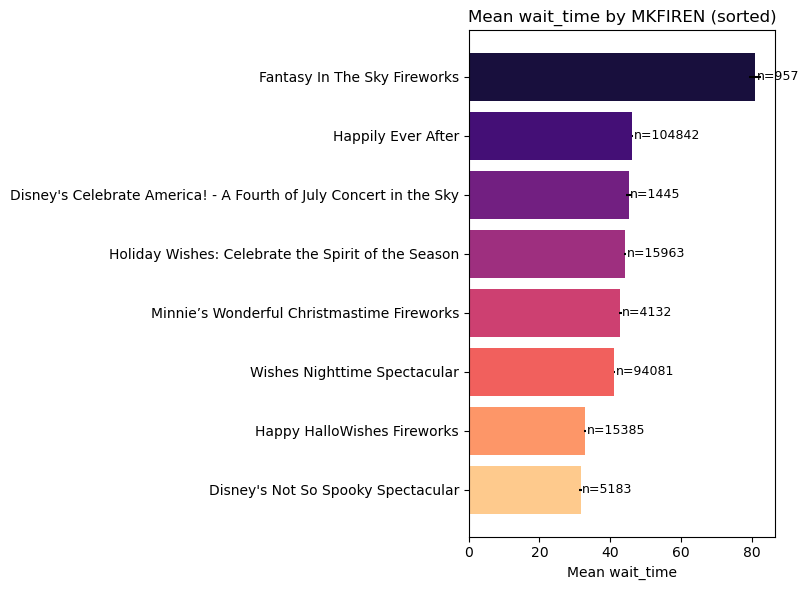

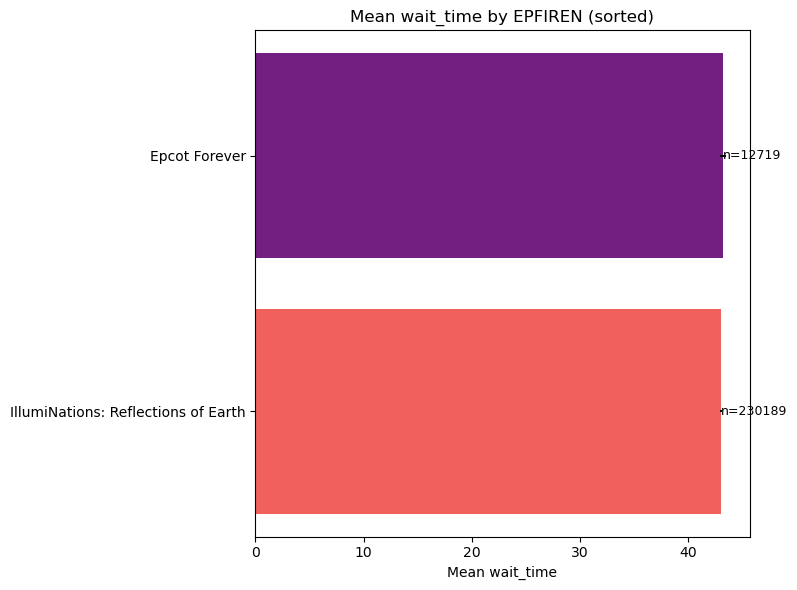

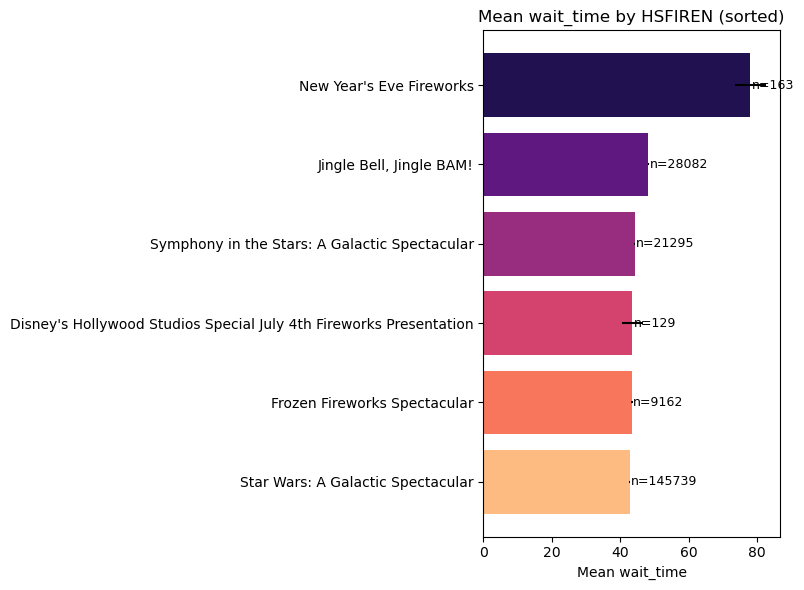

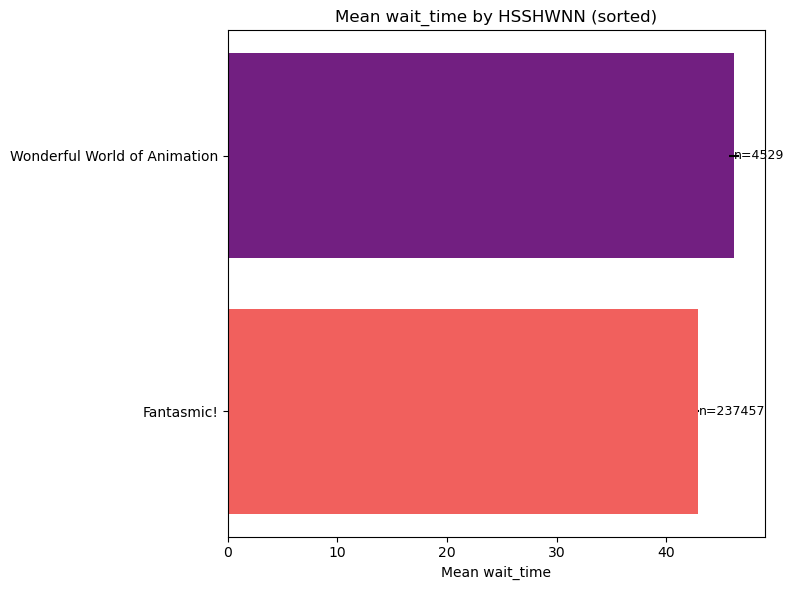

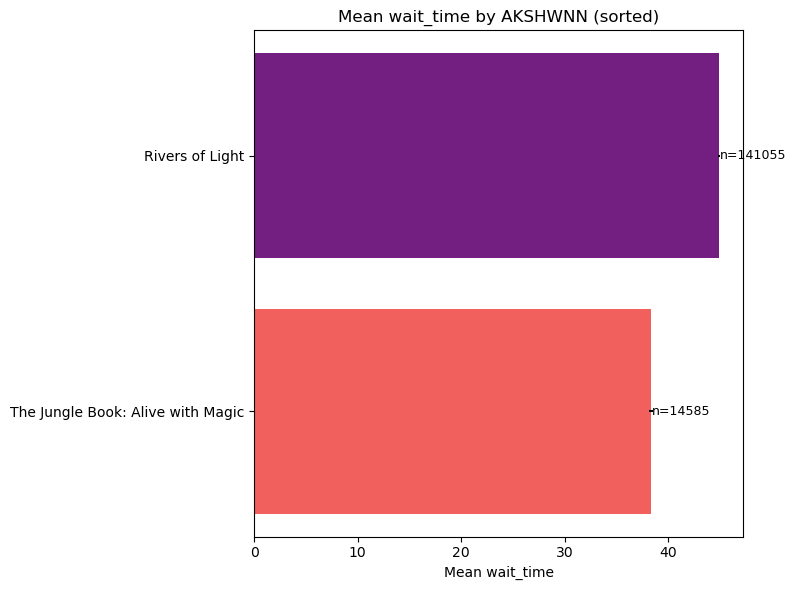

In [77]:
""" This function will help visualize how wait_time varies across different categories."""

def plot_mean_by_category(df, col, value='wait_time', min_count=1, show_se=True,
                          figsize=(8,6), palette='magma'):

    grp = df.groupby(col, observed = True)[value].agg(['mean','count','std']).reset_index()
    grp = grp[grp['count'] >= min_count].copy()
    grp['sem'] = grp['std'] / np.sqrt(grp['count'].replace(0, np.nan))
    grp = grp.sort_values('mean', ascending=False)

    fig, ax = plt.subplots(figsize=figsize)
    y = np.arange(len(grp))
    colors = sns.color_palette(palette, len(grp))

    ax.barh(y, grp['mean'], xerr=grp['sem'] if show_se else None, color=colors)
    ax.set_yticks(y)
    ax.set_yticklabels(grp[col])
    ax.invert_yaxis()  
    ax.set_xlabel(f'Mean {value}')
    ax.set_title(f'Mean {value} by {col} (sorted)')

    # add count labels at end of bars
    for i, (m, c) in enumerate(zip(grp['mean'], grp['count'])):
        ax.text(m + 0.01 * (grp['mean'].max() - grp['mean'].min()), i,
                f'n={int(c)}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

for col in existing_alphanumeric:
    plot_mean_by_category(disney_df, col, value='wait_time', min_count=10, show_se=True)


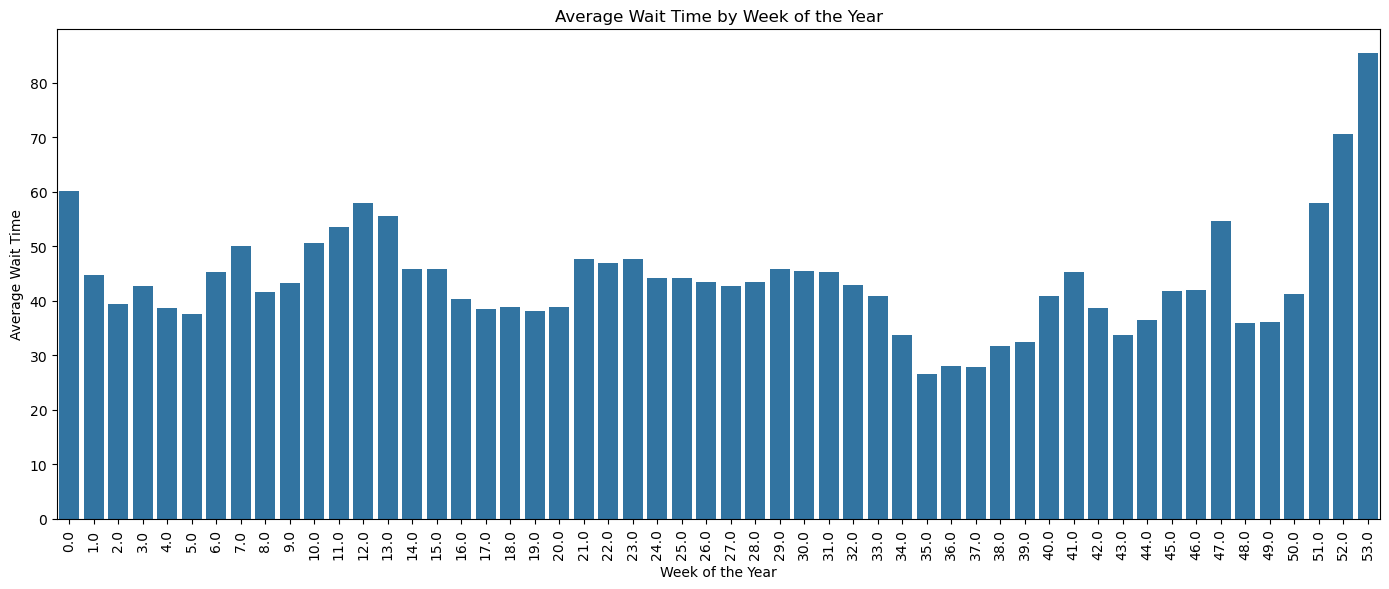

In [78]:
#  want to look at averge wait times aross the year first by week, then by month...

weekly = (disney_df.groupby('WEEKOFYEAR', observed=True)['wait_time']
          .mean()
          .reset_index(name='wait_time'))


weekly = weekly.sort_values('WEEKOFYEAR')

# plot
plt.figure(figsize=(14,6))
ax = sns.barplot(data=weekly, x='WEEKOFYEAR', y='wait_time', color='C0')
ax.set_title('Average Wait Time by Week of the Year')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Average Wait Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [79]:
disney_df['MONTHOFYEAR'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

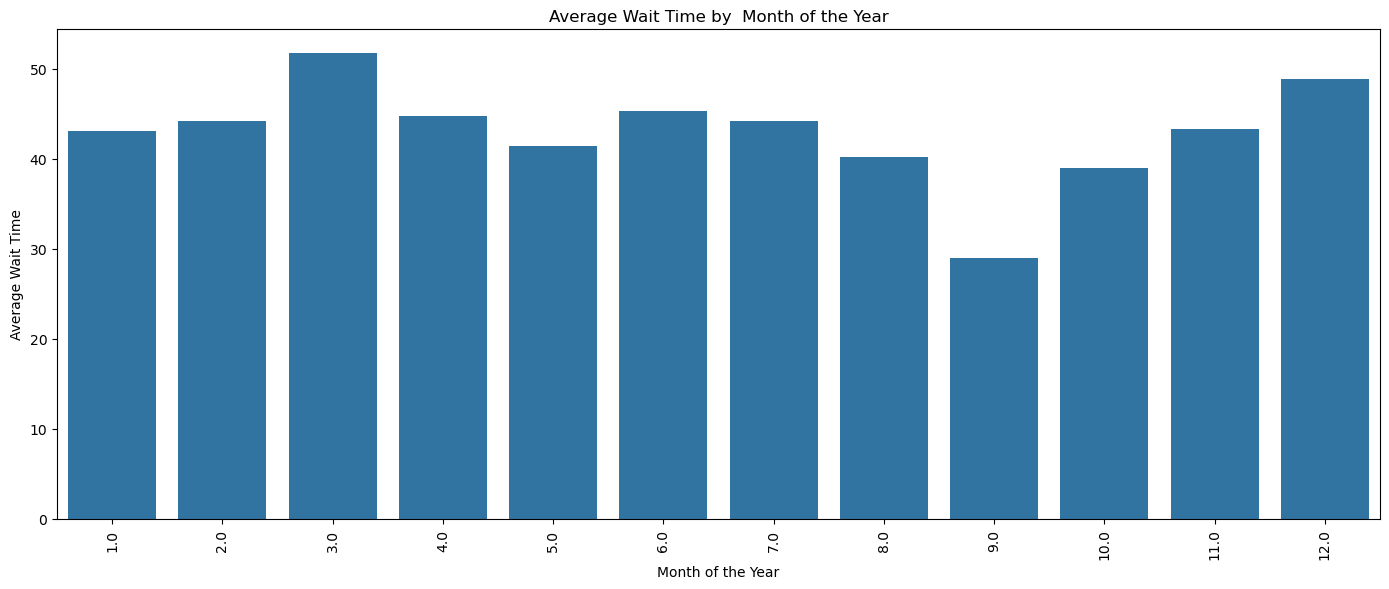

In [80]:
#  want to look at averge wait times aross the year first by week, then by month...

monthly = (disney_df.groupby('MONTHOFYEAR', observed=True)['wait_time']
          .mean()
          .reset_index(name='wait_time'))


monthly = monthly.sort_values('MONTHOFYEAR')

plt.figure(figsize=(14,6))
ax = sns.barplot(data=monthly, x= 'MONTHOFYEAR', y='wait_time', color= 'C0')
ax.set_title('Average Wait Time by  Month of the Year')
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Average Wait Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [81]:
disney_df[['datetime','DAYOFWEEK']].head()

,datetime,DAYOFWEEK
0,2015-01-01 07:00:00,5.0
1,2015-01-01 08:00:00,5.0
2,2015-01-01 09:00:00,5.0
3,2015-01-01 10:00:00,5.0
4,2015-01-01 11:00:00,5.0


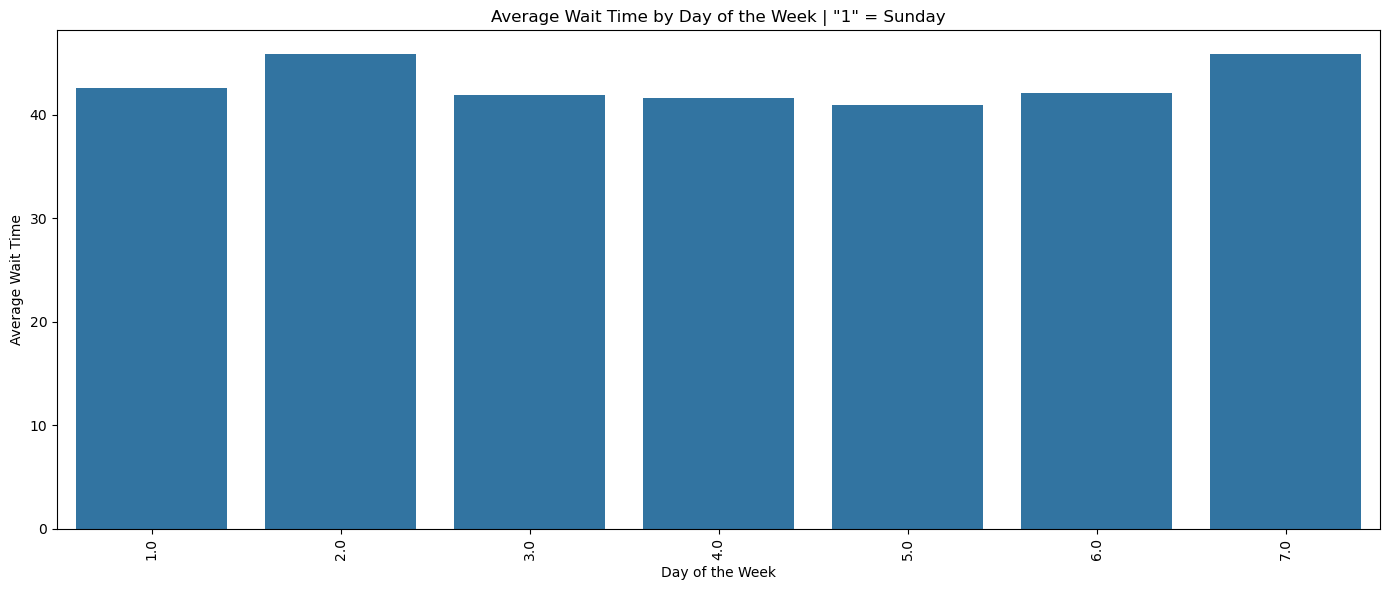

In [82]:
#  want to look at averge wait times aross the year first by week, then by month...

day = (disney_df.groupby('DAYOFWEEK', observed=True)['wait_time']
          .mean()
          .reset_index(name='wait_time'))


day = day.sort_values('DAYOFWEEK')

plt.figure(figsize=(14,6))
ax = sns.barplot(data=day, x= 'DAYOFWEEK', y='wait_time', color= 'C0')
ax.set_title('Average Wait Time by Day of the Week | "1" = Sunday')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Wait Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [83]:
#interesting to note that Mondays and Saturdays have the highest wait times.
#  will look at hour waiti times throughtout the day

disney_df['hour']=disney_df['hour'].astype('category')


Text(0, 0.5, 'wait_time')

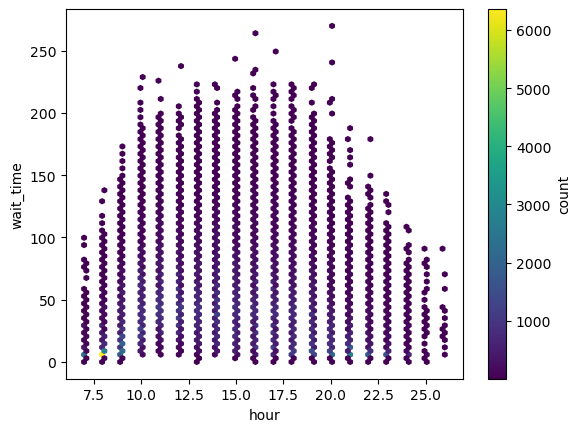

In [84]:
plt.hexbin(disney_df['hour'], disney_df['wait_time'], gridsize=80, cmap='viridis', mincnt=1)
plt.colorbar(label='count'); plt.xlabel('hour'); plt.ylabel('wait_time')



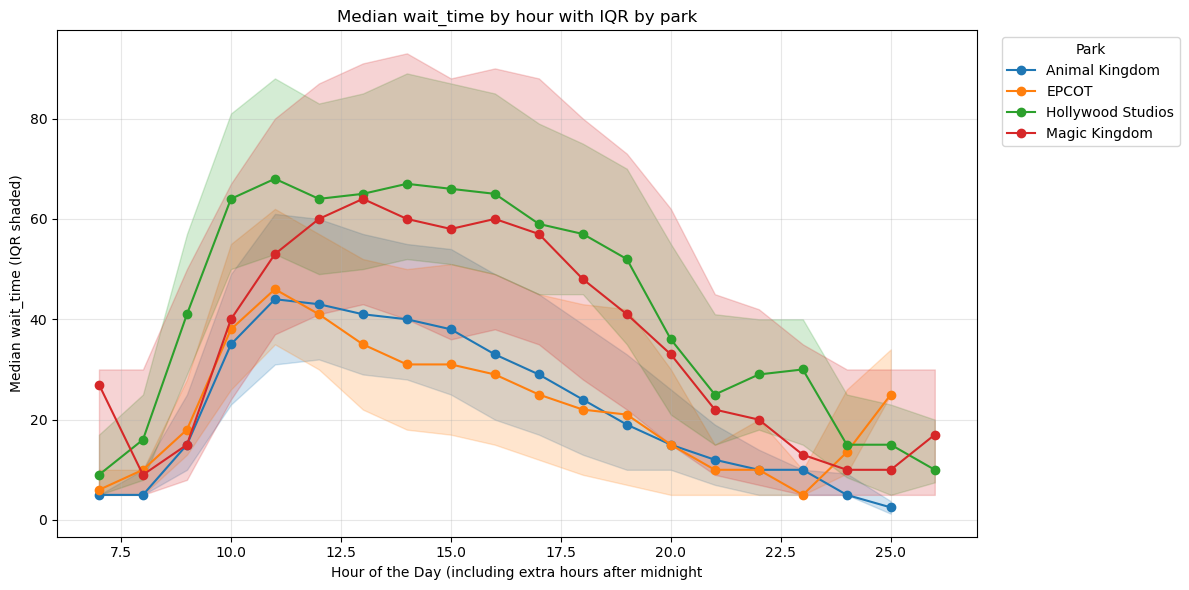

In [85]:
#  gonna look at the hours per day per park.

disney_df.groupby(['parks','hour'], observed=True)['wait_time'].agg(['count','median','mean']).reset_index()

park_col = 'parks'  

hourly = (disney_df.groupby([park_col, 'hour'], observed=True)['wait_time']
          .agg(median='median',
               q1=lambda x: x.quantile(0.25),
               q3=lambda x: x.quantile(0.75))
          .reset_index()
          .sort_values([park_col, 'hour']))

plt.figure(figsize=(12,6))
parks = hourly[park_col].unique()
palette = sns.color_palette("tab10", len(parks))

for color, p in zip(palette, parks):
    dfp = hourly[hourly[park_col] == p]
    x = dfp['hour']
    y = dfp['median']
    y1 = dfp['q1']
    y3 = dfp['q3']

    plt.plot(x, y, label=p, color=color, marker='o')
    plt.fill_between(x, y1, y3, color=color, alpha=0.2)

plt.xlabel('Hour of the Day (including extra hours after midnight')
plt.ylabel('Median wait_time (IQR shaded)')
plt.title('Median wait_time by hour with IQR by park')
plt.legend(title='Park', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



At this point, I have a good grasp on the data and think that the strongest predictors from the Numeric category are  'wait_lag', 'park_avg_wait', 
'park_avg_wait_lag', 'MKHOURS', 'MKHOURSEMH','HOLIDAYM', 'precip_bin', 'temp_bin' and from the categoricals are Season, Holiday, and Events.